In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
from splinter import Browser
from datetime import datetime
import json

from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF, IDF

import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

executable_path = {'executable_path': '/usr/local/bin/chromedriver'}
browser = Browser('chrome', **executable_path, headless=False)

In [2]:
file = "MasterData_Wilson.xlsx"
pd_file = pd.read_excel(file)
bakery_df = pd.DataFrame(pd_file)
bakery_df.head()

,date,time,year,MonthN,Month,WeekN,Day,WeekD,H,Min,...,Price,Quantity,Modifiers,Subtotal,Discounts,Net Total,Tax,Total Due,Unnamed: 29,Unnamed: 30
0,2016-07-25,2016-07-25 09:04:00,2016.0,7.0,Jul,31.0,25.0,Mon,9.0,4.0,...,2.25,1,0.0,2.25,0.0,2.25,0.05,2.30,NaN,NaN
1,2018-08-27,2018-08-27 19:50:00,2018.0,8.0,Aug,35.0,27.0,Mon,19.0,50.0,...,-8.50,15,0.0,-127.50,0.0,-127.50,-13.05,-140.55,NaN,NaN
2,2017-01-30,2017-01-30 10:39:00,2017.0,1.0,Jan,6.0,30.0,Mon,10.0,39.0,...,-7.00,18,-2268.0,-126.00,0.0,-126.00,-2.84,-128.84,NaN,NaN
3,2018-08-27,2018-08-27 19:50:00,2018.0,8.0,Aug,35.0,27.0,Mon,19.0,50.0,...,-9.75,12,0.0,-117.00,0.0,-117.00,-12.00,-129.00,NaN,NaN
4,2018-08-27,2018-08-27 19:50:00,2018.0,8.0,Aug,35.0,27.0,Mon,19.0,50.0,...,-7.75,15,0.0,-116.25,0.0,-116.25,-11.85,-128.10,NaN,NaN


In [11]:
working_bakery_df = bakery_df[['date', 'Rtime', 'WeekN', 'WeekD', 'Operation', 'Line Item', 'Department', 'Category',\
                              'Supplier', 'Supplier Code', 'Cost', 'Price', 'Quantity', 'Modifiers', 'Subtotal',\
                               'Discounts', 'Net Total', 'Tax', 'Total Due']]
working_bakery_df = working_bakery_df.sort_values(by=['date', 'Rtime']).reset_index(drop=True)
working_bakery_df.head()

,date,Rtime,WeekN,WeekD,Operation,Line Item,Department,Category,Supplier,Supplier Code,Cost,Price,Quantity,Modifiers,Subtotal,Discounts,Net Total,Tax,Total Due
0,2016-07-25,09:04:00,31.0,Mon,SALE,Macaron Chocolate,Pastry,general,Cook Au Vin,MACCHO,1.0,2.25,1,0.0,2.25,0.0,2.25,0.05,2.30
1,2016-07-25,09:28:00,31.0,Mon,SALE,Chocolate croissant (to go),Croissants,To Go,Cook Au Vin,CRC,0.0,3.80,1,0.0,3.80,0.0,3.80,0.09,3.89
2,2016-07-25,09:28:00,31.0,Mon,SALE,Latte,Coffee,general,Chicago Beverage Company,CBC,0.0,3.75,1,0.0,3.75,0.0,3.75,0.38,4.13
3,2016-07-25,09:28:00,31.0,Mon,SALE,Type in,general,general,not tracked,0,0.0,2.00,2,0.0,4.00,0.0,4.00,0.09,4.09
4,2016-07-25,09:29:00,31.0,Mon,SALE,Baguette tradition,Bread,general,Cook Au Vin,BTRA,1.4,3.50,1,0.0,3.50,0.0,3.50,0.08,3.58


In [17]:
working_bakery_df['WeekN'] = working_bakery_df['WeekN'].fillna(0.0).astype(int)
working_bakery_df['WeekN'] = working_bakery_df['WeekN'].astype(int)

In [21]:
working_bakery_df.loc[pd.isna(working_bakery_df['Rtime']), :]
working_bakery_df = working_bakery_df.drop(index=416580).reset_index(drop=True)

In [22]:
working_bakery_df = working_bakery_df.rename(columns={'date' : 'Date'})
working_bakery_df.to_csv('../data/bakery_data.csv')

In [26]:
damen_reviews = []
belmont_reviews = []
logan_reviews = []
fournette_reviews = []

damen_bakeries = ["https://www.yelp.com/biz/la-boulangerie-chicago-4?sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=20&sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=40&sort_by=date_desc", \
                  "https://www.yelp.com/biz/la-boulangerie-chicago-4?start=60&sort_by=date_desc"]
belmont_bakeries = ['https://www.yelp.com/biz/la-boulangerie-chicago-2?sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=20&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=40&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=60&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=80&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=100&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=120&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=140&sort_by=date_desc', \
                       'https://www.yelp.com/biz/la-boulangerie-chicago-2?start=160&sort_by=date_desc']
logan_bakeries = ['https://www.yelp.com/biz/la-boulangerie-chicago-8?sort_by=date_desc', \
                 'https://www.yelp.com/biz/la-boulangerie-chicago-8?start=20&sort_by=date_desc']
la_fournette = ['https://www.yelp.com/biz/la-fournette-chicago-3?sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=20&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=40&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=60&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=80&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=100&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=120&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=140&sort_by=date_desc',\
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=160&sort_by=date_desc', \
               'https://www.yelp.com/biz/la-fournette-chicago-3?start=1800&sort_by=date_desc']

In [24]:
def yelp_bakery_lookup(bakery_list, review_list):
    for link in bakery_list:
        bakery_response = requests.get(link)
        bakery_soup = bs(bakery_response.text, 'html.parser')
        bakery_results = bakery_soup.body.find_all('div', class_='review--with-sidebar')
        for review in bakery_results:
            user_info = []
            user_stats = []
            user_name = '' 
            user_loc = ''
            user_friends = ''
            user_reviews = ''
            user_photos = ''
            review_info = []
            review_stars = ''
            review_date = ''
            review_text = ''
            user_check_ins = ''
            elite = ''
            elite_status = ''
            photo = []
            photo_links = []
            review_data = []
            previous_review = []
            previous_rating = []

            user_information = {}

            try:
                user_info = review.find('ul', class_='user-passport-info')
                user_stats = review.find('ul', class_='user-passport-stats')
                review_info = review.find('div', class_='review-content')
                review_footer = review.find('div', class_='review-footer')

                try:
                    user_name = user_info.find('li', class_='user-name').find('a').text.strip()
                    user_profile_link = user_info.find('a', class_='user-display-name').attrs['href']
                    user_profile_link = "https://www.yelp.com" + user_profile_link
                    user_loc = user_info.find('li', class_='user-location').find('b').text.strip()
                    review_stars = review_info.find('div', class_='i-stars').attrs['title']
                    review_stars = int(float(review_stars.split()[0]))
                    review_date = review_info.find('span', class_='rating-qualifier').text.strip()
                    review_text = review_info.find('p').text
                except AttributeError as error:
                    print(error)

                try:
                    user_friends = user_stats.find('li', class_='friend-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_friends = '0'

                try:
                    user_reviews = user_stats.find('li', class_='review-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_reviews = '0'

                try:
                    user_photos = user_stats.find('li', class_='photo-count').find('b').text.strip()
                except AttributeError as error:
                    if user_stats:
                        user_photos = '0'

                try:
                    elite = user_stats.find('li', class_='is-elite')
                    if elite:
                        elite_status = 'elite'
                    else:
                        elite_status = 'not elite'
                except AttributeError as error:
                    print(error)

                try:
                    user_check_ins = review_info.find('li', class_='review-tags_item').find('span').text.strip()
                    user_check_ins = user_check_ins.split()[0]
                except AttributeError as error:
                    if review_info:
                        user_check_ins = '0'

                try:
                    photos = review_info.find('ul', class_='photo-box-grid')
                    if photos:
                        try:
                            picture = photos.find_all('div', class_='photo-box')
                            for pic in picture:
                                pic_link = ''
                                pic_link = pic.find('img').attrs['data-async-src']
                                photo_links.append(pic_link)
                        except Exception as error:
                            print(error)

                except AttributeError as error:
                    if review_info:
                        photo_links = []

                try:
                    review_options = review_footer.find_all('li', class_='vote-item')
                    review_data = {
                        'review_type' : [],
                        'review_count' : []
                    }
                    for option in review_options:
                        review_type = ''
                        review_count = ''
                        review_type = option.find('a').find('span', class_='vote-type').text.strip()
                        review_count = option.find('a').find('span', class_='count').text.strip()
                        if review_count == '':
                            review_count = '0'
                        review_data['review_type'].append(review_type)
                        review_data['review_count'].append(review_count)
                except AttributeError as error:
                    print(error)

                try:
                    previous_review = review.find('div', class_='previous-review')
                    if previous_review:
                        prev_star = previous_review.find('div', class_='i-stars').attrs['title']
                        prev_star = int(float(prev_star.split()[0]))
                        prev_date = previous_review.find('span', class_='rating-qualifier').text.strip()
                        prev_text = previous_review.find('span', class_=['hidden']).text.strip()
                        prev_review_options = previous_review.find_all('li', class_='vote-item')
                        prev_review_data = {
                            'review_type' : [],
                            'review_count' : []
                        }
                        for option in prev_review_options:
                            review_type = ''
                            review_count = ''
                            review_type = option.find('a').find('span', class_='vote-type').text.strip()
                            review_count = option.find('a').find('span', class_='count').text.strip()
                            if review_count == '':
                                review_count = '0'
                            prev_review_data['review_type'].append(review_type)
                            prev_review_data['review_count'].append(review_count)
                        previous_rating = {
                            'stars' : prev_star,
                            'review_date' : prev_date,
                            'review_text' : prev_text,
                            'review_feedback' : prev_review_data
                        }
                except AttributeError as error:
                    previous_review = []
                    print(error)

                if (user_name and user_loc and user_friends and user_reviews and user_photos and review_stars \
                    and review_date and user_check_ins and user_profile_link and review_text):
                    try:
                        user_check_ins = int(user_check_ins)
                    except ValueError as error:
                        user_check_ins = 0
                    counts = review_data['review_count']
                    user_information = {
                        'user_name' : user_name,
                        'user_location' : user_loc,
                        'user_link' : user_profile_link,
                        'user_friends' : int(user_friends),
                        'user_reviews' : int(user_reviews),
                        'user_photos' : int(user_photos),
                        'stars' : review_stars,
                        'review_date' : review_date,
                        'review_text' : review_text,
                        'review_photos' : photo_links,
                        'useful_rating_count' : counts[0],
                        'funny_rating_count' : counts[1],
                        'cool_rating_count' : counts[2],
                        'check_ins' : user_check_ins,
                        'elite_status' : elite_status,
                        'previous_review' : previous_rating
                    }

                    review_list.append(user_information)
            except AttributeError as error:
                print(error)

In [27]:
yelp_bakery_lookup(damen_bakeries, damen_reviews)
yelp_bakery_lookup(belmont_bakeries, belmont_reviews)
yelp_bakery_lookup(logan_bakeries, logan_reviews)
yelp_bakery_lookup(la_fournette, fournette_reviews)

'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'text'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find'
'NoneT

In [28]:
print(len(damen_reviews))
print(len(belmont_reviews))
print(len(logan_reviews))
print(len(fournette_reviews))

72
176
38
180


In [30]:
damen_review_df = pd.DataFrame(damen_reviews)
damen_review_df.head()

,check_ins,cool_rating_count,elite_status,funny_rating_count,previous_review,review_date,review_photos,review_text,stars,useful_rating_count,user_friends,user_link,user_location,user_name,user_photos,user_reviews
0,1,0,elite,0,[],1/7/2019,[https://s3-media3.fl.yelpcdn.com/bphoto/cjkFN...,I've been here twice. Located next to the Fren...,4,2,1222,https://www.yelp.com/user_details?userid=rr6MS...,"Chicago, IL",Jen J.,2273,553
1,0,0,not elite,0,"{'stars': 5, 'review_date': '6/2/2018 ...",1/3/2019\n \n\n\n\n\n\nUpdated review,[],I just stopped by this cafe for the first time...,5,0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",Sonja M.,2,22
2,0,1,elite,1,[],12/31/2018,[],I adore this neighborhood bakery. It is a few ...,5,0,263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",Courtney J.,10,61
3,1,0,elite,0,[],12/23/2018,[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,I've been dreaming of quiche and croissants as...,5,0,196,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",Sabrina G.,82,52
4,0,1,elite,0,[],10/10/2018,[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,We came to La Boulangerie after recommendation...,5,0,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",Alfie B.,326,107


In [31]:
belmont_review_df = pd.DataFrame(belmont_reviews)
logan_review_df = pd.DataFrame(logan_reviews)
fournette_review_df = pd.DataFrame(fournette_reviews)

In [32]:
damen_review_df.columns

Index(['check_ins', 'cool_rating_count', 'elite_status', 'funny_rating_count',
       'previous_review', 'review_date', 'review_photos', 'review_text',
       'stars', 'useful_rating_count', 'user_friends', 'user_link',
       'user_location', 'user_name', 'user_photos', 'user_reviews'],
      dtype='object')

In [33]:
damen_review_df = damen_review_df.rename(columns={'cool_rating_count' : 'Cool', 'elite_status' : 'elite', \
                                                 'funny_rating_count' : 'Funny', 'review_date' : 'Date', \
                                                 'review_photos' : 'Photos', 'review_text' : 'Text', 'stars' : 'Stars',\
                                                 'useful_rating_count' : 'Useful'})

In [34]:
belmont_review_df = belmont_review_df.rename(columns={'cool_rating_count' : 'Cool', 'elite_status' : 'elite', \
                                                 'funny_rating_count' : 'Funny', 'review_date' : 'Date', \
                                                 'review_photos' : 'Photos', 'review_text' : 'Text', 'stars' : 'Stars',\
                                                 'useful_rating_count' : 'Useful'})
logan_review_df = logan_review_df.rename(columns={'cool_rating_count' : 'Cool', 'elite_status' : 'elite', \
                                                 'funny_rating_count' : 'Funny', 'review_date' : 'Date', \
                                                 'review_photos' : 'Photos', 'review_text' : 'Text', 'stars' : 'Stars',\
                                                 'useful_rating_count' : 'Useful'})
fournette_review_df = fournette_review_df.rename(columns={'cool_rating_count' : 'Cool', 'elite_status' : 'elite', \
                                                 'funny_rating_count' : 'Funny', 'review_date' : 'Date', \
                                                 'review_photos' : 'Photos', 'review_text' : 'Text', 'stars' : 'Stars',\
                                                 'useful_rating_count' : 'Useful'})

In [35]:
damen_review_df.columns

Index(['check_ins', 'Cool', 'elite', 'Funny', 'previous_review', 'Date',
       'Photos', 'Text', 'Stars', 'Useful', 'user_friends', 'user_link',
       'user_location', 'user_name', 'user_photos', 'user_reviews'],
      dtype='object')

In [37]:
damen_review_df = damen_review_df[['user_name', 'Date', 'Stars', 'elite', 'Text', 'Cool', 'Funny', 'Useful',\
                                  'check_ins', 'previous_review', 'Photos', 'user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
damen_review_df.head()

,user_name,Date,Stars,elite,Text,Cool,Funny,Useful,check_ins,previous_review,Photos,user_friends,user_link,user_location,user_photos,user_reviews
0,Jen J.,1/7/2019,4,elite,I've been here twice. Located next to the Fren...,0,0,2,1,[],[https://s3-media3.fl.yelpcdn.com/bphoto/cjkFN...,1222,https://www.yelp.com/user_details?userid=rr6MS...,"Chicago, IL",2273,553
1,Sonja M.,1/3/2019\n \n\n\n\n\n\nUpdated review,5,not elite,I just stopped by this cafe for the first time...,0,0,0,0,"{'stars': 5, 'review_date': '6/2/2018 ...",[],63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
2,Courtney J.,12/31/2018,5,elite,I adore this neighborhood bakery. It is a few ...,1,1,0,0,[],[],263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",10,61
3,Sabrina G.,12/23/2018,5,elite,I've been dreaming of quiche and croissants as...,0,0,0,1,[],[https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8...,196,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",82,52
4,Alfie B.,10/10/2018,5,elite,We came to La Boulangerie after recommendation...,1,0,0,0,[],[https://s3-media4.fl.yelpcdn.com/bphoto/oLYVK...,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",326,107


In [38]:
belmont_review_df = belmont_review_df[['user_name', 'Date', 'Stars', 'elite', 'Text', 'Cool', 'Funny', 'Useful',\
                                  'check_ins', 'previous_review', 'Photos', 'user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
logan_review_df = logan_review_df[['user_name', 'Date', 'Stars', 'elite', 'Text', 'Cool', 'Funny', 'Useful',\
                                  'check_ins', 'previous_review', 'Photos', 'user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
fournette_review_df = fournette_review_df[['user_name', 'Date', 'Stars', 'elite', 'Text', 'Cool', 'Funny', 'Useful',\
                                  'check_ins', 'previous_review', 'Photos', 'user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]

In [45]:
def rearrange_prev_reviews(dataframe_name):
    for index, row in dataframe_name.iterrows():
        if len(row['Date']) > 15:
            print(f"Update!")
            dataframe_name.loc[index, 'Updated'] = '1'
            prev = row.previous_review
            try:
                dataframe_name.loc[index, 'prev_text'] = prev['review_text']
                dataframe_name.loc[index, 'prev_stars'] = prev['stars']
                dataframe_name.loc[index, 'prev_date'] = prev['review_date']
                counts = prev['review_feedback']['review_count']
                dataframe_name.loc[index, 'prev_useful'] = counts[0]
                dataframe_name.loc[index, 'prev_funny'] = counts[1]
                dataframe_name.loc[index, 'prev_cool'] = counts[2]
            except TypeError as error:
                print(error)
        else:
            dataframe_name.loc[index, 'Updated'] = '0'

In [46]:
rearrange_prev_reviews(damen_review_df)
rearrange_prev_reviews(belmont_review_df)
rearrange_prev_reviews(logan_review_df)
rearrange_prev_reviews(fournette_review_df)

Update!
Update!
Update!
Update!
list indices must be integers or slices, not str
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!
Update!


In [47]:
belmont_review_df.head()

,user_name,Date,Stars,elite,Text,Cool,Funny,Useful,check_ins,previous_review,...,user_location,user_photos,user_reviews,Updated,prev_text,prev_stars,prev_date,prev_useful,prev_funny,prev_cool
0,Elise M.,12/27/2018\n \n\n\n\n\n\nUpdated re...,4,not elite,2018 Updated Review:This place closed for seve...,0,0,0,0,"{'stars': 5, 'review_date': '10/7/2017 ...",...,"Chicago, IL",13,36,1,They have a Gourmet Breakfast Sandwich that is...,5.0,10/7/2017\n \nPrevious review,1,0,0
1,John D.,7/1/2018\n \n\n\n\n\n\nUpdated review,5,not elite,Such a beautiful pleasant atmosphere. Highly r...,0,0,0,0,[],...,"Chicago, IL",0,134,1,NaN,NaN,NaN,NaN,NaN,NaN
2,Hunny B.,5/3/2018,4,not elite,I am reluctant to write this review because I ...,0,0,0,0,[],...,"Chicago, IL",14,31,0,NaN,NaN,NaN,NaN,NaN,NaN
3,Tee L.,3/21/2018,4,not elite,Cute lil set up with courteous staff. First ti...,0,0,0,0,[],...,"Chicago, IL",423,139,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Rose O.,3/9/2018,4,not elite,Their caprese sandwich is just OK but i really...,0,0,0,1,[],...,"Chicago, IL",1,98,0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
belmont_review_df.columns

Index(['user_name', 'Date', 'Stars', 'elite', 'Text', 'Cool', 'Funny',
       'Useful', 'check_ins', 'previous_review', 'Photos', 'user_friends',
       'user_link', 'user_location', 'user_photos', 'user_reviews', 'Updated',
       'prev_text', 'prev_stars', 'prev_date', 'prev_useful', 'prev_funny',
       'prev_cool'],
      dtype='object')

In [51]:
damen_review_df = damen_review_df[['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text', 'Cool', 'Funny', \
                                   'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars', 'prev_date', \
                                   'prev_useful', 'prev_funny', 'prev_cool','user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
belmont_review_df = belmont_review_df[['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text', 'Cool', 'Funny', \
                                   'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars', 'prev_date', \
                                   'prev_useful', 'prev_funny', 'prev_cool','user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
logan_review_df = logan_review_df[['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text', 'Cool', 'Funny', \
                                   'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars', 'prev_date', \
                                   'prev_useful', 'prev_funny', 'prev_cool','user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]
fournette_review_df = fournette_review_df[['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text', 'Cool', 'Funny', \
                                   'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars', 'prev_date', \
                                   'prev_useful', 'prev_funny', 'prev_cool','user_friends', 'user_link', \
                                   'user_location', 'user_photos', 'user_reviews']]

In [52]:
damen_review_df.loc[damen_review_df['Updated'] == '1', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
1,Sonja M.,1/3/2019\n \n\n\n\n\n\nUpdated review,5,not elite,1,I just stopped by this cafe for the first time...,0,0,0,0,...,5.0,6/2/2018\n \nPrevious review,0,0,0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
25,Allyson M.,4/1/2018\n \n\n\n\n\n\nUpdated review,4,not elite,1,I dont see that UNfriendly guy anymore in the ...,0,0,0,0,...,3.0,3/3/2018\n \nPrevious review,0,1,0,0,https://www.yelp.com/user_details?userid=iWYTd...,"Chicago, IL",0,12


In [55]:
def fix_date(dataframe_name):
    for index, row in dataframe_name.iterrows():
        if len(row['Date']) > 15:
            try:
                dataframe_name.loc[index, 'Date'] = row['Date'].split('\n')[0]
                dataframe_name.loc[index, 'prev_date'] = row['prev_date'].split('\n')[0]
            except AttributeError as error:
                print(error)

In [56]:
fix_date(damen_review_df)
fix_date(belmont_review_df)
fix_date(logan_review_df)
fix_date(fournette_review_df)

'float' object has no attribute 'split'


In [57]:
damen_review_df.loc[damen_review_df['Updated'] == '1', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
1,Sonja M.,1/3/2019,5,not elite,1,I just stopped by this cafe for the first time...,0,0,0,0,...,5.0,6/2/2018,0,0,0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
25,Allyson M.,4/1/2018,4,not elite,1,I dont see that UNfriendly guy anymore in the ...,0,0,0,0,...,3.0,3/3/2018,0,1,0,0,https://www.yelp.com/user_details?userid=iWYTd...,"Chicago, IL",0,12


In [58]:
belmont_review_df.loc[belmont_review_df['Updated'] == '1', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
0,Elise M.,12/27/2018,4,not elite,1,2018 Updated Review:This place closed for seve...,0,0,0,0,...,5.0,10/7/2017,1,0,0,0,https://www.yelp.com/user_details?userid=TY4Ct...,"Chicago, IL",13,36
1,John D.,7/1/2018,5,not elite,1,Such a beautiful pleasant atmosphere. Highly r...,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,1,https://www.yelp.com/user_details?userid=5AL4m...,"Chicago, IL",0,134
61,Danielle S.,9/19/2015,4,not elite,1,Pleasantly surprised! We were looking for a ne...,1,0,1,0,...,4.0,9/5/2015,0,0,1,73,https://www.yelp.com/user_details?userid=M_ODP...,"Chicago, IL",236,68
70,Sam M.,6/25/2015,5,not elite,1,La Boulangerie has stepped its game up! My big...,0,0,1,1,...,1.0,4/22/2014,4,1,1,2,https://www.yelp.com/user_details?userid=gzeCe...,"Chicago, IL",1,10
80,Charlotte F.,3/18/2015,4,not elite,1,"In response to the message from the owner, my ...",0,0,0,1,...,4.0,7/8/2014,0,0,0,55,https://www.yelp.com/user_details?userid=EN2Pg...,"Chicago, IL",33,119
119,Daniel C.,2/18/2014,4,not elite,1,Bumping my review up a star based on the Wisco...,3,1,4,7,...,3.0,12/3/2013,0,0,0,166,https://www.yelp.com/user_details?userid=bLmwH...,"Orlando, FL",58,380
139,Izzy N.,7/20/2013,1,not elite,1,It's hot outside AND inside albeit a fan blowi...,6,11,13,1,...,3.0,10/12/2012,3,3,3,677,https://www.yelp.com/user_details?userid=FyaI7...,"Portland, OR",413,892


In [61]:
#Manually Adding information scraper missed for prev review John D
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_date']] = '12/31/2016'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_text']] = 'great breakfast croissant, good value! \
Try it'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_stars']] = '5'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_cool']] = '0'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_funny']] = '0'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', ['prev_useful']] = '0'
belmont_review_df.loc[belmont_review_df['user_name'] == 'John D.', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
1,John D.,7/1/2018,5,not elite,1,Such a beautiful pleasant atmosphere. Highly r...,0,0,0,0,...,5,12/31/2016,0,0,0,1,https://www.yelp.com/user_details?userid=5AL4m...,"Chicago, IL",0,134


In [63]:
logan_review_df.loc[logan_review_df['Updated'] == '1', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
1,Erin H.,12/29/2018,5,not elite,1,This place has the BEST croissant I've had in ...,0,0,0,1,...,5.0,10/8/2018,0,0,0,120,https://www.yelp.com/user_details?userid=Y0Yt3...,"Chicago, IL",15,64
18,Dina F.,7/10/2018,5,not elite,1,Always may favorite! I was so bummed when they...,1,1,2,12,...,4.0,7/5/2018,1,1,0,43,https://www.yelp.com/user_details?userid=_4qel...,"Chicago, IL",86,87


In [64]:
fournette_review_df.loc[fournette_review_df['Updated'] == '1', :]

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
5,Carrie D.,10/20/2018,5,not elite,1,Love this place! I go every week to get a lat...,0,0,0,1,...,5.0,9/18/2018,0,0,0,0,https://www.yelp.com/user_details?userid=I3_wC...,"Crystal Lake, IL",0,4
10,Samantha W.,9/24/2018,5,not elite,1,This spot has the definition of excellent cust...,1,0,2,0,...,5.0,6/22/2018,0,0,0,195,https://www.yelp.com/user_details?userid=KWxvk...,"Chicago, IL",37,18
49,Nolan M.,1/21/2018,5,not elite,1,"My favorite place in Old Town. Family-run, aut...",0,0,0,1,...,5.0,12/17/2017,0,0,0,0,https://www.yelp.com/user_details?userid=hXU8q...,"San Francisco, CA",1,4
71,Tory w.,7/12/2017,1,not elite,1,"Update: UGH. Looking at my previous review, I...",1,3,1,1,...,3.0,8/28/2015,0,0,0,66,https://www.yelp.com/user_details?userid=DYR7A...,"Chicago, IL",5,253
109,Tim H.,8/13/2016,5,not elite,1,"Great croissants, macaroons, and baguettes. T...",1,0,0,1,...,4.0,4/25/2015,0,0,0,128,https://www.yelp.com/user_details?userid=lNsZD...,"Chicago, IL",110,537
116,Yulia Y.,7/9/2016,5,not elite,1,"The best, officially absolutely the best crois...",0,0,0,0,...,5.0,5/28/2016,0,0,0,1,https://www.yelp.com/user_details?userid=iTwrY...,"Belvidere, IL",32,19


In [69]:
def elite_bool_rating_type(dataframe_name):
    for index, row in dataframe_name.iterrows():
        if row['elite'] == 'elite':
            dataframe_name.loc[index, ['elite']] = 1
        elif row['elite'] == 'not elite':
            dataframe_name.loc[index, ['elite']] = 0
    dataframe_name['Useful'] = pd.to_numeric(dataframe_name['Useful'])
    dataframe_name['Funny'] = pd.to_numeric(dataframe_name['Funny'])
    dataframe_name['Cool'] = pd.to_numeric(dataframe_name['Cool'])
    dataframe_name['prev_useful'] = pd.to_numeric(dataframe_name['prev_useful'])
    dataframe_name['prev_funny'] = pd.to_numeric(dataframe_name['prev_funny'])
    dataframe_name['prev_cool'] = pd.to_numeric(dataframe_name['prev_cool'])

In [70]:
elite_bool_rating_type(damen_review_df)
elite_bool_rating_type(belmont_review_df)
elite_bool_rating_type(logan_review_df)
elite_bool_rating_type(fournette_review_df)

In [71]:
damen_review_df.head()

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,1222,https://www.yelp.com/user_details?userid=rr6MS...,"Chicago, IL",2273,553
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,5.0,6/2/2018,0.0,0.0,0.0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",10,61
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,196,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",82,52
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",326,107


In [72]:
damen_review_df.to_csv('../data/damen_reviews.csv')
belmont_review_df.to_csv('../data/belmont_reviews.csv')
logan_review_df.to_csv('../data/logan_reviews.csv')
fournette_review_df.to_csv('../data/fournette_reviews.csv')

In [73]:
school_link = 'https://www.lyceechicago.org/calendar?mini='
year_list = ['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', \
             '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', \
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', \
             '2018-10', '2018-11']
event_list=[]

In [74]:
for month in year_list:
    new_link = school_link + month
    school_response = requests.get(new_link)
    school_soup = bs(school_response.text, 'html.parser')
    events = school_soup.find_all('td', class_='has-events')
    for e in events:
        event_link = e.find('div').find('a').attrs['href']
        event_list.append(event_link)

In [75]:
len(event_list)

153

In [76]:
event_details = []
for event in event_list:
    date = event.split('/')
    date = date[len(date)-1]
    event_response = requests.get(event)
    event_soup = bs(event_response.text, 'html.parser')
    events_that_day = event_soup.find('div', class_='view-content').find_all('div', class_='views-row')
    for event in events_that_day:
        title = event.find('h3', class_='field-content').find('a').text.strip()
        time_frame = event.find('span', class_='date-display-single').text.strip()
        event_l = event.find('h3', class_='field-content').find('a').attrs['href']
        info = {
            'event_title' : title,
            'event_time' : time_frame,
            'event_date' : date,
            'event_link' : 'https://www.lyceechicago.org' + event_l
        }
        event_details.append(info)
print(json.dumps(event_details, indent=4, sort_keys=True))

[
    {
        "event_date": "2016-08-22",
        "event_link": "https://www.lyceechicago.org/calendar/back-to-school-prep-for-staff",
        "event_time": "(All day)",
        "event_title": "Back to School Prep for New Teachers"
    },
    {
        "event_date": "2016-08-23",
        "event_link": "https://www.lyceechicago.org/calendar/back-to-school-prep-for-staff",
        "event_time": "(All day)",
        "event_title": "Back to School Prep for New Teachers"
    },
    {
        "event_date": "2016-08-24",
        "event_link": "https://www.lyceechicago.org/calendar/back-to-school-prep-for-all-staff-0",
        "event_time": "(All day)",
        "event_title": "Back to School Prep for All Staff"
    },
    {
        "event_date": "2016-08-25",
        "event_link": "https://www.lyceechicago.org/calendar/back-to-school-prep-for-all-staff-0",
        "event_time": "(All day)",
        "event_title": "Back to School Prep for All Staff"
    },
    {
        "event_date": "2016-08

In [77]:
print(len(event_details))
print(len(event_list))

153
153


In [78]:
lychee_event_df = pd.DataFrame(event_details)
lychee_event_df.head()

,event_date,event_link,event_time,event_title
0,2016-08-22,https://www.lyceechicago.org/calendar/back-to-...,(All day),Back to School Prep for New Teachers
1,2016-08-23,https://www.lyceechicago.org/calendar/back-to-...,(All day),Back to School Prep for New Teachers
2,2016-08-24,https://www.lyceechicago.org/calendar/back-to-...,(All day),Back to School Prep for All Staff
3,2016-08-25,https://www.lyceechicago.org/calendar/back-to-...,(All day),Back to School Prep for All Staff
4,2016-08-26,https://www.lyceechicago.org/calendar/back-to-...,(All day),Back to School Prep for All Staff


In [79]:
for index, row in lychee_event_df.iterrows():
    if row['event_time'] == '(All day)':
        lychee_event_df.loc[index, 'event_time'] = 'All day'
        lychee_event_df.loc[index, 'start_time'] = '12:00 am'
        lychee_event_df.loc[index, 'end_time'] = '11:59 pm'
    else:
        time_list = row['event_time'].split(' ')
        if len(time_list) > 2:
            lychee_event_df.loc[index, 'start_time'] = time_list[0] + ' ' + time_list[1]
            lychee_event_df.loc[index, 'end_time'] = time_list[3] + ' ' + time_list[4]
        else:
            lychee_event_df.loc[index, 'start_time'] = time_list[0] + ' ' + time_list[1]

In [80]:
lychee_event_df.head()

,event_date,event_link,event_time,event_title,start_time,end_time
0,2016-08-22,https://www.lyceechicago.org/calendar/back-to-...,All day,Back to School Prep for New Teachers,12:00 am,11:59 pm
1,2016-08-23,https://www.lyceechicago.org/calendar/back-to-...,All day,Back to School Prep for New Teachers,12:00 am,11:59 pm
2,2016-08-24,https://www.lyceechicago.org/calendar/back-to-...,All day,Back to School Prep for All Staff,12:00 am,11:59 pm
3,2016-08-25,https://www.lyceechicago.org/calendar/back-to-...,All day,Back to School Prep for All Staff,12:00 am,11:59 pm
4,2016-08-26,https://www.lyceechicago.org/calendar/back-to-...,All day,Back to School Prep for All Staff,12:00 am,11:59 pm


In [81]:
lychee_event_df['event_title'].value_counts()

Spring Recess                                                                                                 24
Holiday Recess - School Closed                                                                                16
Holiday Recess - School closed                                                                                15
Fall Recess                                                                                                   14
Winter Recess - School Closed                                                                                  8
Thanksgiving Break - School Closed                                                                             8
Winter Recess                                                                                                  8
Fall Recess - School closed                                                                                    5
Start'Up Lycée                                                                                  

In [82]:
for index, row in lychee_event_df.iterrows():
    if row['event_title'] == 'Thanksgiving - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Thanksgiving Break - School Closed'
    if row['event_title'] == 'Fall Recess':
        lychee_event_df.loc[index, 'event_title'] = 'Fall Recess - School Closed'  
    if row['event_title'] == 'Fall Recess - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Fall Recess - School Closed' 
    if row['event_title'] == 'Holiday Recess - School closed':
        lychee_event_df.loc[index, 'event_title'] = 'Holiday Recess - School Closed'
    if row['event_title'] == 'Winter Recess':
        lychee_event_df.loc[index, 'event_title'] = 'Winter Recess - School Closed'  
    if row['event_title'] == 'Memorial Day – School Closed':
        lychee_event_df.loc[index, 'event_title'] = 'Memorial Day - School Closed'
    if row['event_title'] == 'Parent - teacher Conferences - No school for students':
        lychee_event_df.loc[index, 'event_title'] = 'Parent - Teacher Conferences - No School for Students'  
    if row['event_title'] == 'Parent –Teacher Conferences - No School for Students':
        lychee_event_df.loc[index, 'event_title'] = 'Parent - Teacher Conferences - No School for Students' 
    if row['event_title'] == 'In Service Day for Staff - No School for students':
        lychee_event_df.loc[index, 'event_title'] = 'In Service Day for Staff - No School for Students' 

In [120]:
lychee_event_df.to_csv('../data/lychee_events.csv')

In [84]:
spark = SparkSession.builder.appName('nlp_yelp').getOrCreate()
tokenizer = Tokenizer(inputCol="Text", outputCol="Words")
remover = StopWordsRemover(inputCol="Words", outputCol="Filtered")
idf = IDF(inputCol="HashedFilteredValues", outputCol="Features")

In [94]:
damen_nlp_list = []
belmont_nlp_list = []
logan_nlp_list = []
fournette_nlp_list = []

In [95]:
def clean_text(dataframe_name, feature_num, nlp_list):
    for index, row in dataframe_name.iterrows():
        sentence = row.Text.lower()
        sentence = sentence.replace('.', ' ')
        sentence = sentence.replace('!', ' ')
        sentence = sentence.replace(',', ' ')
        sentence = sentence.replace(', ', ' ')
        sentence = sentence.replace('(', ' ')
        sentence = sentence.replace(')', ' ')
        sentence = sentence.replace(' - ', '')
        sentence = sentence.replace('&', 'and')
        sentence = sentence.replace('w/', 'with')
        sentence = sentence.replace('review:', 'review : ')
        sentence = sentence.replace('?', '')
        sentence = sentence.replace('"', '')
        sentence = sentence.replace('*', '')
        sentence = sentence.replace('...', ' ')
        sentence = sentence.replace(';', '')
        sentence = sentence.replace('- ', ' ')
        sentence = sentence.replace(' -', ' ')
        sentence = sentence.replace('/', ' ')
        sentence = sentence.replace('    ', ' ')
        sentence = sentence.replace('   ', ' ')
        sentence = sentence.replace('  ', ' ')
        sentence = sentence.replace('\xa0', '')
        sentence = sentence.replace('thatif', 'that if')
        sentence = sentence.replace('rightwould', 'right would')
        sentence = sentence.replace('croissantthe', 'croissant the')
        sentence = sentence.replace('storefrontspastries', 'storefronts pastries')
        sentence = sentence.replace('macaroonsstaff', 'macaroons staff')
        sentence = sentence.replace('crosiant', 'croissant')
        sentence = sentence.replace('crossiant', 'croissant')
        sentence = sentence.replace('againbut', 'again but')
        sentence = sentence.replace('toobut', 'too but')
        sentence = sentence.replace('flavorfulinteresting', 'flavorful interesting')
        sentence = sentence.replace('bcuz', 'because')
        sentence = sentence.replace('morethe', 'more the')
        sentence = sentence.replace('nicerconclusion', 'nicer conclusion')
        sentence = sentence.replace('nowyou', 'now you')
        sentence = sentence.replace('macaron', 'macaroon')
        sentence = sentence.replace('Belomont', 'Belmont')
        sentence = sentence.replace('againlatte', 'again latte')
        sentence = sentence.replace('loganthe', 'logan the')
        sentence = sentence.replace('editadding', 'edit adding')
        sentence = sentence.replace('wowgreat', 'wow great')
        sentence = sentence.replace('americanogoodbut', 'americano good but')
        sentence = sentence.replace('servicewill', 'service will')
        sentence = sentence.replace('greatbut', 'great but')
        sentence = sentence.replace('muffingood', 'muffin good')
        sentence = sentence.replace('badnot', 'bad not')
        sentence = sentence.replace('goodin', 'good in')
        sentence = sentence.replace('insideor', 'inside or')
        sentence = sentence.replace('livelywe', 'lively we')
        sentence = sentence.replace('offeringsmy', 'offeringsmy')
        sentence = sentence.replace('mediocrethe', 'mediocre the')
        sentence = sentence.replace('reviewambience', 'review ambience')
        sentence = sentence.replace('nice_________________________been', 'nice been')
        sentence = sentence.replace('breakfast3', 'breakfast 3')
        sentence = sentence.replace('offeringsmy', 'offerings my')
        sentence = sentence.replace('resultsthe', 'results the')
        sentence = sentence.replace('crunchy-on-the-outside-yet-soft-on-the-inside', 'crunchy on the outside yet soft on the inside')
        sentence = sentence.replace('choices--the', 'choices the')
        sentence = sentence.replace('macaroonsyumno', 'macaroons')
        sentence = sentence.replace('pastriesyes', 'pastries yes')
        sentence = sentence.replace('[', '')
        sentence = sentence.replace(']', '')
        sentence = sentence.replace('vey', 'very')
        sentence = sentence.replace('good-my', 'good my')
        sentence = sentence.replace('favourite', 'favorite')
        sentence = sentence.replace('areaplush', 'area plush')
        sentence = sentence.replace('crowdfrom', 'crowd from')
        sentence = sentence.replace("macaroonthey're", "macaroon they're")
        sentence = sentence.replace("speakingpossibly", "speaking possibly")
        sentence = sentence.replace("servicewill", "service will")
        sentence = sentence.replace("5service", "5 service")
        sentence = sentence.replace("goodlobster", "good lobster")
        sentence = sentence.replace("baguette-excellent", "baguette excellent")
        sentence = sentence.replace("flour-per", "flour per")
        sentence = sentence.replace("excellentfar", "excellent far")
        sentence = sentence.replace("yayatmospherecute", "yay atmosphere cute")
        sentence = sentence.replace("againnot", "again not")
        sentence = sentence.replace("all-", "all")
        sentence = sentence.replace("amazingcrisp", "amazing crisp")
        sentence = sentence.replace("ambiance", "ambience")
        sentence = sentence.replace("ambience:", "ambience")
        sentence = sentence.replace("specialtyeverything", "specialty everything")
        sentence = sentence.replace("amnot", "am not")
        sentence = sentence.replace("--", " ")
        sentence = sentence.replace("arrivesbut", "arrives but")
        sentence = sentence.replace("asked:", "asked")
        sentence = sentence.replace("authenticfrom", "authentic from")
        sentence = sentence.replace("badbaked", "bad baked")
        sentence = sentence.replace("baguette-excellent", "baguette excellent")
        sentence = sentence.replace("baguette-herbed", "baguette herbed")
        sentence = sentence.replace("baguettesi'll", "baguettes i'll")
        sentence = sentence.replace("bakerythey", "bakery they")
        sentence = sentence.replace("bathroomsshared", "bathrooms shared")
        sentence = sentence.replace("because:1", "because 1")
        sentence = sentence.replace("belive", "believe")
        sentence = sentence.replace("bitenot", "bite not")
        sentence = sentence.replace("bonbonslastly", "bonbons lastly")
        sentence = sentence.replace("boulangerie-spanish", "boulangerie spanish")
        sentence = sentence.replace("bourgeoius", "bourgeois")
        sentence = sentence.replace("buildingand", "building and")
        sentence = sentence.replace("buttery-sweet", "buttery sweet")
        sentence = sentence.replace("caramelthat", "caramel that")
        sentence = sentence.replace("carmelquiche", "caramel quiche")
        sentence = sentence.replace("carmel", "caramel")
        sentence = sentence.replace("chicagodiverse", "chicago diverse")
        sentence = sentence.replace("chicagothe", "chicago the")
        sentence = sentence.replace("chicagowe", "chicago we")
        sentence = sentence.replace("chocolate-coconut", "chocolate coconut")
        sentence = sentence.replace("citywhenever", "city whenever")
        sentence = sentence.replace("chip+1", "chip +1")    
        sentence = sentence.replace("ciabata", "ciabatta")
        sentence = sentence.replace("club:", "club")
        sentence = sentence.replace("customerservice", "customer service")
        sentence = sentence.replace("desserts:", "desserts")
        sentence = sentence.replace("dirty:", "dirty")
        sentence = sentence.replace("drink+1", "drink +1")
        sentence = sentence.replace("eachquiche:", "each quiche")
        sentence = sentence.replace("womanoverall", "woman overall")
        sentence = sentence.replace("zuccini", "zucchini")
        sentence = sentence.replace("wrongthere", "wrong there")
        sentence = sentence.replace("wonderfuli", "wonderful i")
        sentence = sentence.replace("withfresh", "with fresh")
        sentence = sentence.replace("well:", "well")
        sentence = sentence.replace("unfotunately", "unfortunately")
        sentence = sentence.replace("update:", "update")
        sentence = sentence.replace("time:", "time")
        sentence = sentence.replace("so:", "so")
        sentence = sentence.replace("timefrom", "time from")
        sentence = sentence.replace("termsoverpriced", "terms overpriced")
        sentence = sentence.replace("summerjust", "summer just")
        sentence = sentence.replace("soupeclairchocolate", "soup eclair chocolate")
        sentence = sentence.replace("servicethe", "service the")
        sentence = sentence.replace("service:", "service")
        sentence = sentence.replace("sandwich-look", "sandwich look")
        sentence = sentence.replace("sandwich:", "sandwich")
        sentence = sentence.replace("quichebasil", "quiche basil")
        sentence = sentence.replace("receiptclerk", "receipt clerk")
        sentence = sentence.replace("offthey're", "off they're")
        sentence = sentence.replace("paris'", "paris")
        sentence = sentence.replace("macaroonsyum", "macaroons yum")
        sentence = sentence.replace("macaroons:", "macaroons")
        sentence = sentence.replace("lineif", "line if")
        sentence = sentence.replace("line:", "line")
        sentence = sentence.replace("earsbut", "ears but")
        info = (index, sentence)
        nlp_list.append(info)
    print(len(nlp_list))

In [96]:
clean_text(damen_review_df, feature_num, damen_nlp_list)
clean_text(belmont_review_df, feature_num, belmont_nlp_list)
clean_text(logan_review_df, feature_num, logan_nlp_list)
clean_text(fournette_review_df, feature_num, fournette_nlp_list)

72
176
38
180


In [92]:
#Hashing num set to 3000 for now, will rehash after obtaining actual num of unique words
feature_num = 3000

In [102]:
def NLP_Time(nlp_list, feature_num):
    hashing = HashingTF(inputCol="Filtered", outputCol="HashedFilteredValues", numFeatures=(feature_num*1.2))
    dataframe = spark.createDataFrame(nlp_list,["id", "Text"])
    tokenized = tokenizer.transform(dataframe)
    removed = remover.transform(tokenized)
    hashed_df = hashing.transform(removed)
    idfModel = idf.fit(hashed_df)
    rescaledData = idfModel.transform(hashed_df)
    return rescaledData.toPandas()

In [104]:
damen_nlp_df = NLP_Time(damen_nlp_list, feature_num)
belmont_nlp_df = NLP_Time(belmont_nlp_list, feature_num)
logan_nlp_df = NLP_Time(logan_nlp_list, feature_num)
fournette_nlp_df = NLP_Time(fournette_nlp_list, feature_num)

In [106]:
fournette_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,0,oh my goodness can i give this place more star...,"[oh, my, goodness, can, i, give, this, place, ...","[oh, goodness, give, place, stars, little, fre...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,love this place it's near my house and always ...,"[love, this, place, it's, near, my, house, and...","[love, place, near, house, always, delicious, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,i love this place cute little french bakery on...,"[i, love, this, place, cute, little, french, b...","[love, place, cute, little, french, bakery, we...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,amazing sourdough bread and price is competiti...,"[amazing, sourdough, bread, and, price, is, co...","[amazing, sourdough, bread, price, competitive...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,even though it says dog friendly on yelp it is...,"[even, though, it, says, dog, friendly, on, ye...","[even, though, says, dog, friendly, yelp, sign...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [121]:
def get_num_unique_words(dataframe_name, location_name):
    uniq_master_array = []
    for index, row in dataframe_name.iterrows():
        uniq_master_array = uniq_master_array + row.Filtered
    print(f'{location_name} {len(uniq_master_array)} total words')
    uniq_master_set = set(uniq_master_array)
    print(f'{location_name} {len(uniq_master_set)} unique words')
    return uniq_master_array

In [122]:
damen_master_array = get_num_unique_words(damen_nlp_df, 'Damen')
belmont_master_array = get_num_unique_words(belmont_nlp_df, 'Belmont')
logan_master_array = get_num_unique_words(logan_nlp_df, 'Logan')
fournette_master_array = get_num_unique_words(fournette_nlp_df, 'Fournette')

Damen 3848 total words
Damen 1461 unique words
Belmont 9059 total words
Belmont 2473 unique words
Logan 1766 total words
Logan 833 unique words
Fournette 6412 total words
Fournette 1846 unique words


In [113]:
# Rerun NLP to have more accurate HashNum values
damen_feat = 1500
belmont_feat = 2500
logan_feat = 850
fournette_feat = 1900
damen_nlp_df = NLP_Time(damen_nlp_list, damen_feat)
belmont_nlp_df = NLP_Time(belmont_nlp_list, belmont_feat)
logan_nlp_df = NLP_Time(logan_nlp_list, logan_feat)
fournette_nlp_df = NLP_Time(fournette_nlp_list, fournette_feat)

In [114]:
fournette_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features
0,0,oh my goodness can i give this place more star...,"[oh, my, goodness, can, i, give, this, place, ...","[oh, goodness, give, place, stars, little, fre...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.6431489697764121, 0.0, 0.0, ..."
1,1,love this place it's near my house and always ...,"[love, this, place, it's, near, my, house, and...","[love, place, near, house, always, delicious, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,i love this place cute little french bakery on...,"[i, love, this, place, cute, little, french, b...","[love, place, cute, little, french, bakery, we...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,amazing sourdough bread and price is competiti...,"[amazing, sourdough, bread, and, price, is, co...","[amazing, sourdough, bread, price, competitive...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,even though it says dog friendly on yelp it is...,"[even, though, it, says, dog, friendly, on, ye...","[even, though, says, dog, friendly, yelp, sign...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [115]:
def IDF_mean(dataframe_name):
    word_sum = 0
    for index, row in dataframe_name.iterrows():
        word_array = []
        length = 0
        for value in list(dataframe_name.loc[dataframe_name.index == index, ['Features']].values[0][0]):
            if value != 0.0:
                word_array.append(value)
        length = len(row['Filtered'])
        word_sum = sum(word_array)
        dataframe_name.loc[index, 'IDF_Mean'] = word_sum/length

In [116]:
IDF_mean(damen_nlp_df)
IDF_mean(belmont_nlp_df)
IDF_mean(logan_nlp_df)
IDF_mean(fournette_nlp_df)

In [118]:
damen_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features,IDF_Mean
0,0,i've been here twice located next to the frenc...,"[i've, been, here, twice, located, next, to, t...","[twice, located, next, french, school, cute, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.405276
1,1,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.827953
2,2,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.406096
3,3,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.160080
4,4,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.261238


In [119]:
damen_nlp_df.to_csv('../data/damen_nlp.csv')
belmont_nlp_df.to_csv('../data/belmont_nlp.csv')
logan_nlp_df.to_csv('../data/logan_nlp.csv')
fournette_nlp_df.to_csv('../data/fournette_nlp.csv')

In [133]:
def word_count_df_generator(word_list, branch_name):
    location_word_df = pd.DataFrame(word_list)
    counts = location_word_df.groupby([0])[0].agg(['count'])
    counts = counts.sort_values(['count'],ascending=False)
    counts = counts.rename(columns={'count' : 'word_count'})
    counts['Branch'] = branch_name
    return counts

In [134]:
damen_counts_df = word_count_df_generator(damen_master_array, 'Damen')
belmont_counts_df = word_count_df_generator(belmont_master_array, 'Belmont')
logan_counts_df = word_count_df_generator(logan_master_array, 'Logan')
fournette_counts_df = word_count_df_generator(fournette_master_array, 'Fournette')

In [135]:
counts_master_df = pd.concat([damen_counts_df, belmont_counts_df, logan_counts_df, fournette_counts_df])\
.reset_index(drop=True)
print(len(counts_master_df))

6613


In [136]:
counts_master_df.head()

,word_count,Branch
0,41,Damen
1,40,Damen
2,39,Damen
3,36,Damen
4,35,Damen


In [137]:
counts_master_df.to_csv('../data/word_counts_ALL.csv')

In [138]:
all_boulagerie_array = damen_master_array + belmont_master_array + logan_master_array
all_boulagerie_set = set(all_boulagerie_array)
print(f'{len(all_boulagerie_array)} - La Boul. total words')
print(f'{len(all_boulagerie_set)} - La Boul. unique words')
unique_boulagerie_list = list(all_boulagerie_set)
unique_boulagerie_list.sort()
print(len(unique_boulagerie_list))

14673 - La Boul. total words
3266 - La Boul. unique words
3266


In [139]:
fournette_set = set(fournette_master_array)
print(f'{len(fournette_master_array)} - La Fourn. total words')
print(f'{len(fournette_set)} - La Fourn. unique words')
unique_fournette_list = list(fournette_set)
unique_fournette_list.sort()
print(len(unique_fournette_list))

6412 - La Fourn. total words
1846 - La Fourn. unique words
1846


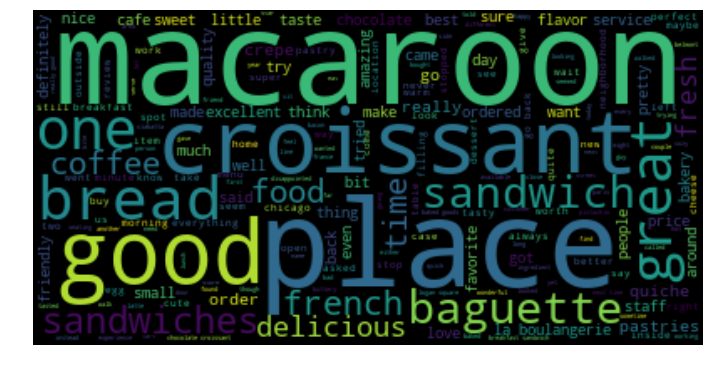

In [145]:
all_boulagerie_array_string = ' '.join(all_boulagerie_array)
wordcloud = WordCloud().generate(all_boulagerie_array_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../images/boulagerie_all_wordcloud.png')

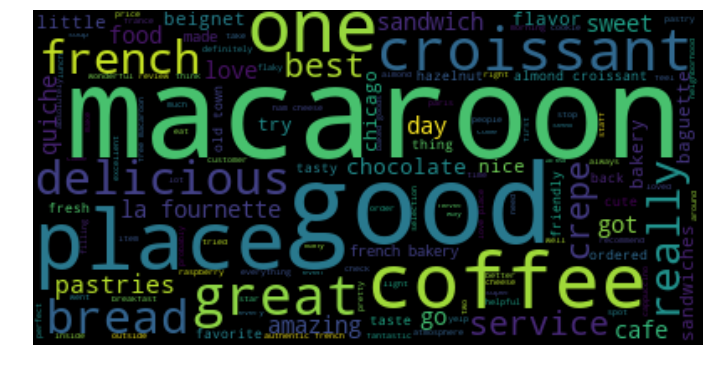

In [144]:
fournette_master_array_string = ' '.join(fournette_master_array)
wordcloud = WordCloud().generate(fournette_master_array_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../images/fournette_all_wordcloud.png')

In [146]:
damen_review_df.head()

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_stars,prev_date,prev_useful,prev_funny,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,1222,https://www.yelp.com/user_details?userid=rr6MS...,"Chicago, IL",2273,553
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,5.0,6/2/2018,0.0,0.0,0.0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",10,61
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,196,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",82,52
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",326,107


In [147]:
damen_nlp_df.head()

,id,Text,Words,Filtered,HashedFilteredValues,Features,IDF_Mean
0,0,i've been here twice located next to the frenc...,"[i've, been, here, twice, located, next, to, t...","[twice, located, next, french, school, cute, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.405276
1,1,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.827953
2,2,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.406096
3,3,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.160080
4,4,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.261238


In [150]:
def vader_analysis(dataframe_name):
    for index, row in dataframe_name.iterrows():
        results = analyzer.polarity_scores(row['Text'])
        dataframe_name.loc[index, 'compound sentiment'] = results['compound'] 
        dataframe_name.loc[index, 'negative sentiment'] = results['neg']
        dataframe_name.loc[index, 'neutral sentiment'] = results['neu']
        dataframe_name.loc[index, 'positive sentiment'] = results['pos']

In [151]:
vader_analysis(damen_review_df)
vader_analysis(belmont_review_df)
vader_analysis(logan_review_df)
vader_analysis(fournette_review_df)

In [152]:
damen_review_df.head()

,user_name,Date,Stars,elite,Updated,Text,Cool,Funny,Useful,check_ins,...,prev_cool,user_friends,user_link,user_location,user_photos,user_reviews,compound sentiment,negative sentiment,neutral sentiment,positive sentiment
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,NaN,1222,https://www.yelp.com/user_details?userid=rr6MS...,"Chicago, IL",2273,553,0.7650,0.000,0.924,0.076
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,0.0,63,https://www.yelp.com/user_details?userid=VtVHE...,"Chicago, IL",2,22,0.7678,0.050,0.841,0.109
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,NaN,263,https://www.yelp.com/user_details?userid=aqkJ_...,"Chicago, IL",10,61,0.9580,0.032,0.796,0.172
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,NaN,196,https://www.yelp.com/user_details?userid=LlGh8...,"Chicago, IL",82,52,-0.0516,0.091,0.821,0.088
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,NaN,17,https://www.yelp.com/user_details?userid=mymQs...,"Columbia, SC",326,107,0.9472,0.000,0.851,0.149


In [153]:
damen_review_df.to_csv('../data/damen_reviews.csv')
belmont_review_df.to_csv('../data/belmont_reviews.csv')
logan_review_df.to_csv('../data/logan_reviews.csv')
fournette_review_df.to_csv('../data/fournette_reviews.csv')

In [154]:
def import_files_to_dataframe(file_name, location):
    csv = location + file_name
    file = pd.read_csv(csv)
    df = pd.DataFrame(file)
    return df

In [155]:
weather_csv = 'weatherresults.csv'
there = '../data/'
here = ''

In [156]:
weather_df = import_files_to_dataframe(weather_csv, here)
weather_df.head()

,Unnamed: 0,Date,Temperature,Precipitation,Summary,Formatted_Date
0,0,1482645600,34.26,0.00,Overcast,2016-12-25
1,1,1482732000,39.56,0.68,Drizzle,2016-12-26
2,2,1482818400,28.81,0.00,Clear,2016-12-27
3,3,1482904800,23.65,0.00,Clear,2016-12-28
4,4,1482991200,34.61,0.00,Clear,2016-12-29


In [ ]:
# fournette_master_array
# all_boulagerie_array
# damen_master_array
# belmont_master_array
# logan_master_array

In [158]:
def merge_nlp_and_review_df(nlp_df, review_df):
    df = pd.merge(review_df, nlp_df, left_index=True, right_index=True)
    return df

In [159]:
damen_nlp_review_merge = merge_nlp_and_review_df(damen_nlp_df, damen_review_df)
belmont_nlp_review_merge = merge_nlp_and_review_df(belmont_nlp_df, belmont_review_df)
logan_nlp_review_merge = merge_nlp_and_review_df(logan_nlp_df, logan_review_df)
fournette_nlp_review_merge = merge_nlp_and_review_df(fournette_nlp_df, fournette_review_df)

In [160]:
damen_nlp_review_merge.head()

,user_name,Date,Stars,elite,Updated,Text_x,Cool,Funny,Useful,check_ins,...,negative sentiment,neutral sentiment,positive sentiment,id,Text_y,Words,Filtered,HashedFilteredValues,Features,IDF_Mean
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,0.000,0.924,0.076,0,i've been here twice located next to the frenc...,"[i've, been, here, twice, located, next, to, t...","[twice, located, next, french, school, cute, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.405276
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,0.050,0.841,0.109,1,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.827953
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,0.032,0.796,0.172,2,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.406096
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,0.091,0.821,0.088,3,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.160080
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,0.000,0.851,0.149,4,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.261238


In [170]:
def get_low_star_list(dataframe):
    list_low = []
    for index, row in dataframe.loc[dataframe['Stars'] < 3, :].iterrows():
        list_low = list_low + row['Filtered']
    return list_low

def get_high_star_list(dataframe):
    list_high = []
    for index, row in dataframe.loc[dataframe['Stars'] > 3, :].iterrows():
        list_high = list_high + row['Filtered']
    return list_high

In [183]:
damen_nlp_review_merge['Branch'] = 'Damen'
damen_nlp_review_merge['Branch_Num'] = 1
belmont_nlp_review_merge['Branch'] = 'Belmont'
belmont_nlp_review_merge['Branch_Num'] = 2
logan_nlp_review_merge['Branch'] = 'Logan'
logan_nlp_review_merge['Branch_Num'] = 3

In [184]:
boul_master_nlp_review_merge = pd.concat([damen_nlp_review_merge, belmont_nlp_review_merge,\
                                         logan_nlp_review_merge]).reset_index(drop=True)

In [171]:
boul_low_star = get_low_star_list(boul_master_nlp_review_merge)
boul_high_star = get_high_star_list(boul_master_nlp_review_merge)
fourn_low_star = get_low_star_list(fournette_nlp_review_merge)
fourn_high_star = get_high_star_list(fournette_nlp_review_merge)

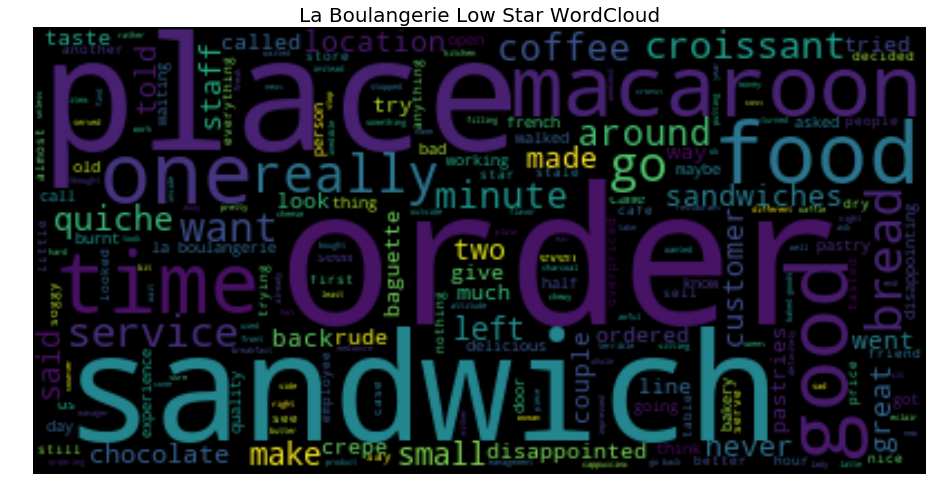

In [318]:
boul_low_master_array_string = ' '.join(boul_low_star)
wordcloud = WordCloud().generate(boul_low_master_array_string)
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("La Boulangerie Low Star WordCloud", fontsize=20)
plt.axis("off")
plt.savefig('../images/boulagerie_low_wordcloud.png')

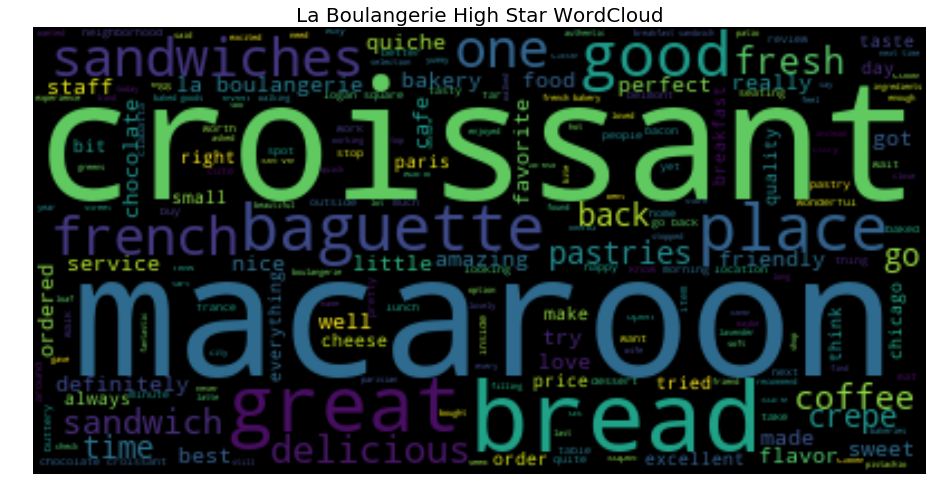

In [319]:
boul_high_master_array_string = ' '.join(boul_high_star)
wordcloud = WordCloud().generate(boul_high_master_array_string)
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("La Boulangerie High Star WordCloud", fontsize=20)
plt.axis("off")
plt.savefig('../images/boulagerie_high_wordcloud.png')

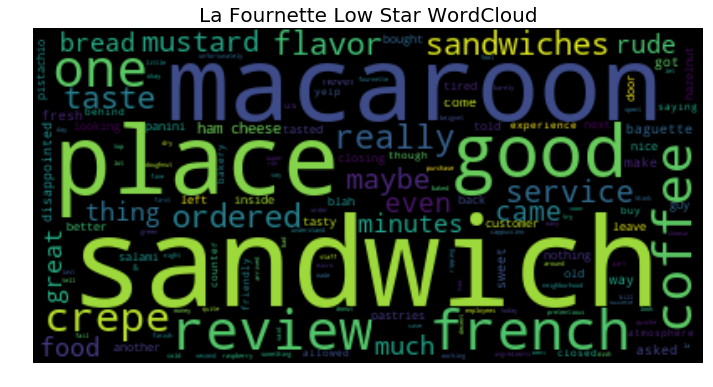

In [277]:
fourn_low_master_array_string = ' '.join(fourn_low_star)
wordcloud = WordCloud().generate(fourn_low_master_array_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("La Fournette Low Star WordCloud", fontsize=20)
plt.axis("off")
plt.savefig('../images/fournette_low_wordcloud.png')

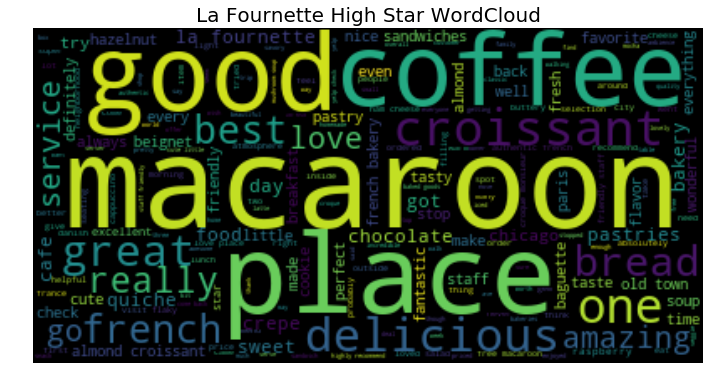

In [280]:
fourn_high_master_array_string = ' '.join(fourn_high_star)
wordcloud = WordCloud().generate(fourn_high_master_array_string)
fig, ax = plt.subplots(figsize=(12, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("La Fournette High Star WordCloud", fontsize=20)
plt.axis("off")
plt.savefig('../images/fournette_high_wordcloud.png')

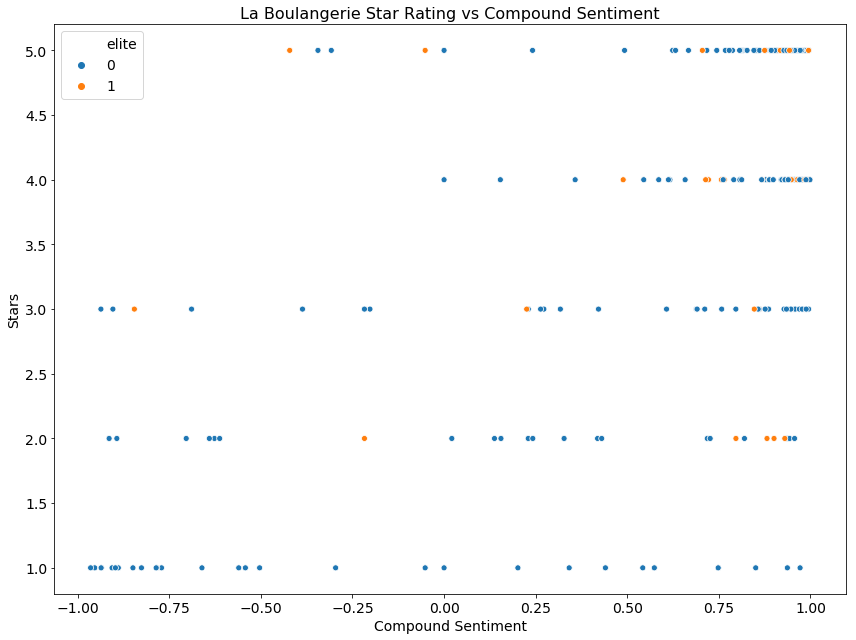

In [340]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(x='compound sentiment', \
                y='Stars', data=boul_master_nlp_review_merge, hue='elite')\
.set_title('La Boulangerie Star Rating vs Compound Sentiment', fontsize=16)
plt.ylabel('Stars', fontsize=14)
plt.xlabel('Compound Sentiment', fontsize=14)
plt.legend(bbox_to_anchor=(.02, .98), loc=2, borderaxespad=0.)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/Scatter_compound_v_stars_boul.png')

In [185]:
boul_master_nlp_review_merge.head()

,user_name,Date,Stars,elite,Updated,Text_x,Cool,Funny,Useful,check_ins,...,positive sentiment,id,Text_y,Words,Filtered,HashedFilteredValues,Features,IDF_Mean,Branch,Branch_Num
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,0.076,0,i've been here twice located next to the frenc...,"[i've, been, here, twice, located, next, to, t...","[twice, located, next, french, school, cute, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.405276,Damen,1
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,0.109,1,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.827953,Damen,1
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,0.172,2,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.406096,Damen,1
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,0.088,3,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.160080,Damen,1
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,0.149,4,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.261238,Damen,1


In [358]:
boul_master_nlp_review_merge = boul_master_nlp_review_merge.rename(columns={'compound sentiment' : 'Sentiment',\
                                                                           'user_reviews' : 'Reviews', \
                                                                           'elite' : 'Elite', 'Filtered Length' : \
                                                                           'Word Count'})

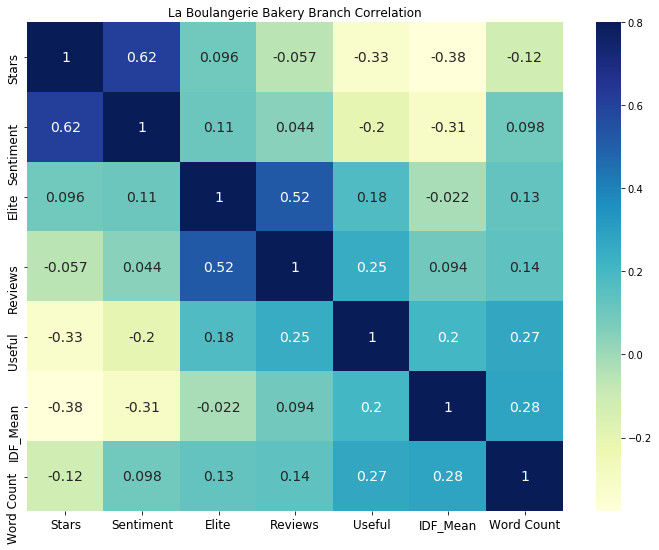

In [359]:
corrmat = boul_master_nlp_review_merge[['Stars', 'Sentiment', 'Elite', \
                                        'Reviews', 'Useful', 'IDF_Mean', 'Word Count']].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns_plot = sns.heatmap(corrmat, vmax=.8, cmap="YlGnBu", annot=True, annot_kws={"size": 14})\
.set_title('La Boulangerie Bakery Branch Correlation')
ax.tick_params(labelsize=12)
plt.savefig('../images/Heatmap_la_boulangerie.png')

In [188]:
boul_master_nlp_review_merge.groupby(['Branch'])['Stars', 'compound sentiment', 'elite', \
                                                 'IDF_Mean'].agg(['mean']).reset_index()

,Branch,Stars,compound sentiment,elite,IDF_Mean
,,mean,mean,mean,mean
0,Belmont,3.545455,0.571502,0.130682,2.684861
1,Damen,4.166667,0.798839,0.208333,2.274037
2,Logan,4.236842,0.774905,0.236842,1.954335


In [189]:
belmont_logan_array = belmont_master_array + logan_master_array
belmont_logan_set = set(belmont_logan_array)
unique_belmont_logan_array = list(belmont_logan_set)
print(len(unique_belmont_logan_array))
print(len(damen_master_array))

2746
3848


In [190]:
d_word_df = pd.DataFrame(damen_master_array)
unique_damen_words = ~d_word_df.loc[d_word_df.index].isin(unique_belmont_logan_array)
unique_damen_words.head()

,0
0,False
1,False
2,False
3,False
4,True


In [191]:
unique_damen_words_merge = pd.merge(unique_damen_words, d_word_df, left_index=True, right_index=True)
unique_damen_words_merge.head()

,0_x,0_y
0,False,twice
1,False,located
2,False,next
3,False,french
4,True,school


In [194]:
unique_damen_words_final = unique_damen_words_merge.loc[unique_damen_words_merge['0_x']==True, :]\
.reset_index(drop=True)
unique_damen_words_final.head()

,0_x,0_y
0,True,school
1,True,millefeuille
2,True,expectations
3,True,doughy
4,True,seasonal


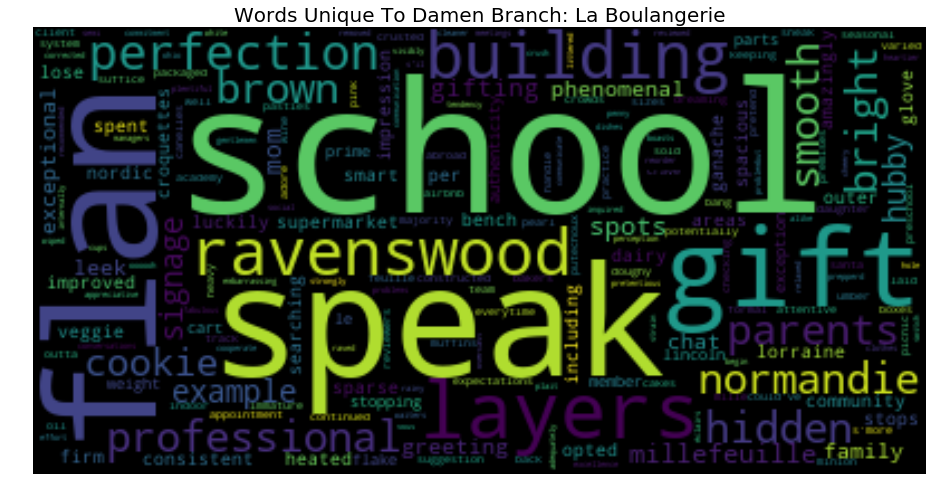

In [320]:
unique_list_final = unique_damen_words_final['0_y'].values
unique_list_string = ' '.join(unique_list_final)
wordcloud = WordCloud().generate(unique_list_string)
fig, ax = plt.subplots(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Words Unique To Damen Branch: La Boulangerie", fontsize=20)
plt.savefig('../images/damen_unique_wordcloud.png')

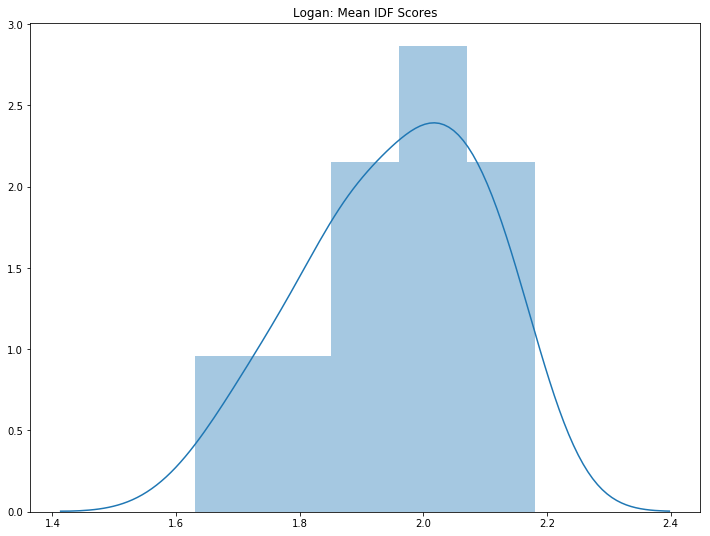

In [207]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.distplot(logan_nlp_df['IDF_Mean'].values).set_title('Logan: Mean IDF Scores')
plt.savefig('../images/logan_IDF.png')

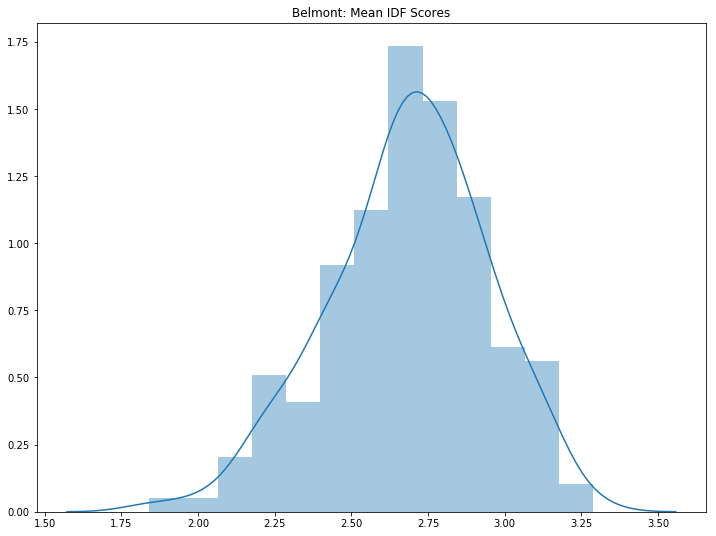

In [229]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.distplot(belmont_nlp_df['IDF_Mean'].values).set_title('Belmont: Mean IDF Scores')
plt.savefig('../images/belmont_IDF.png')

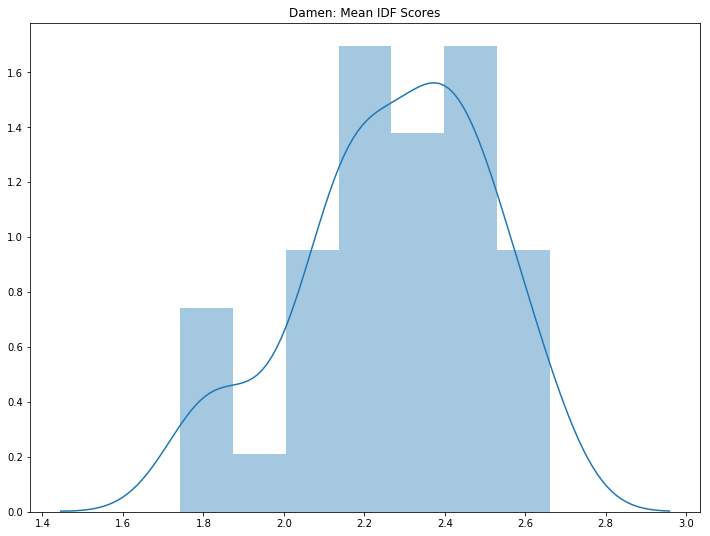

In [209]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.distplot(damen_nlp_df['IDF_Mean'].values).set_title('Damen: Mean IDF Scores')
plt.savefig('../images/damen_IDF.png')

In [286]:
boul_summary_df = boul_master_nlp_review_merge.groupby(['Branch', 'Branch_Num', 'Stars'])['compound sentiment', \
                                                                                          'elite', 'IDF_Mean', 'Filtered Length']\
.agg(['mean']).reset_index()


In [287]:
boul_summary_df

,Branch,Branch_Num,Stars,compound sentiment,elite,IDF_Mean,Filtered Length
,,,,mean,mean,mean,mean
0,Belmont,2,1,-0.291068,0.000000,2.890426,56.640000
1,Belmont,2,2,0.199470,0.200000,2.805381,57.950000
2,Belmont,2,3,0.520212,0.120000,2.650187,54.520000
3,Belmont,2,4,0.850248,0.195652,2.631713,53.086957
4,Belmont,2,5,0.862583,0.116667,2.614232,44.650000
5,Damen,1,1,-0.007667,0.000000,2.195623,21.000000
6,Damen,1,2,0.809500,0.500000,2.529194,42.000000
7,Damen,1,3,0.640538,0.153846,2.378698,74.153846
8,Damen,1,4,0.879619,0.375000,2.371828,69.625000


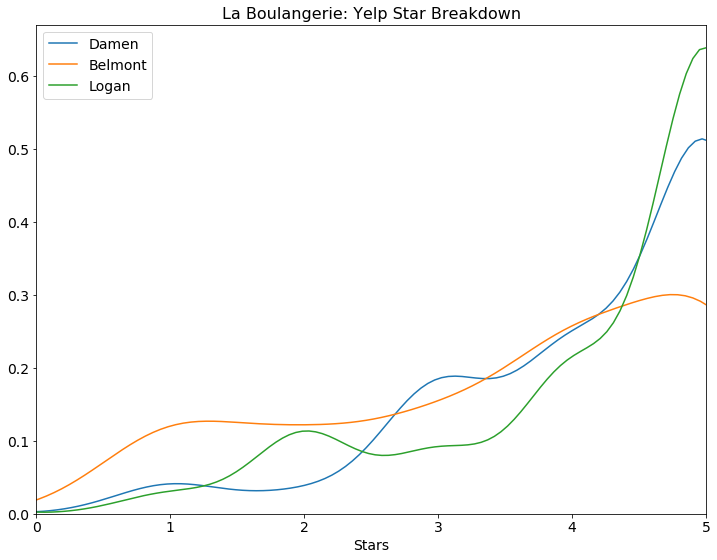

In [336]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(0, 5)
sns.kdeplot(damen_nlp_review_merge['Stars'], label='Damen')
sns.kdeplot(belmont_nlp_review_merge['Stars'], label='Belmont')
sns.kdeplot(logan_nlp_review_merge['Stars'], label='Logan')
plt.xlabel("Stars", fontsize=14)
plt.title("La Boulangerie: Yelp Star Breakdown", fontsize=16)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../images/boul_star_comparisons.png')



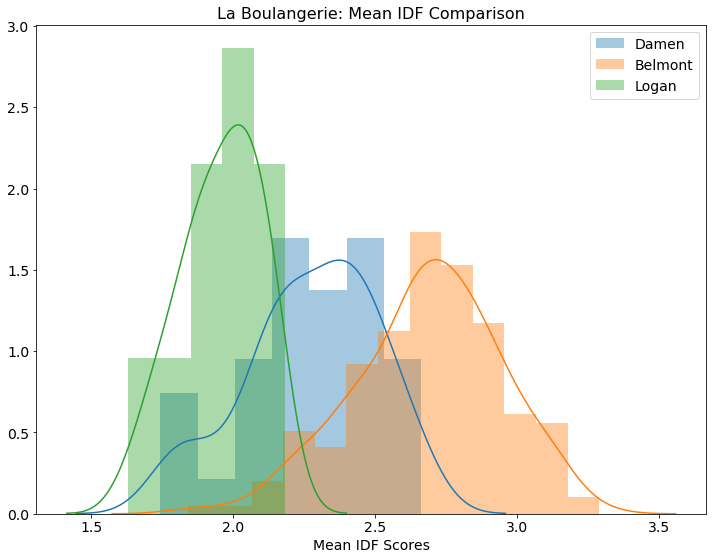

In [338]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.distplot(damen_nlp_df['IDF_Mean'].values, label='Damen')
sns.distplot(belmont_nlp_df['IDF_Mean'].values, label='Belmont')
sns.distplot(logan_nlp_df['IDF_Mean'].values, label='Logan')
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.xlabel("Mean IDF Scores", fontsize=14)
plt.title("La Boulangerie: Mean IDF Comparison", fontsize=16)
plt.savefig('../images/boul_IDF_comparisons.png')                       
                                 

In [246]:
for index, row in boul_master_nlp_review_merge.iterrows():
    boul_master_nlp_review_merge.loc[index, 'Filtered Length'] = \
    len(boul_master_nlp_review_merge.loc[boul_master_nlp_review_merge.index == index, ['Filtered']].values[0][0])
boul_master_nlp_review_merge.head()

,user_name,Date,Stars,elite,Updated,Text_x,Cool,Funny,Useful,check_ins,...,id,Text_y,Words,Filtered,HashedFilteredValues,Features,IDF_Mean,Branch,Branch_Num,Filtered Length
0,Jen J.,1/7/2019,4,1,0,I've been here twice. Located next to the Fren...,0,0,2,1,...,0,i've been here twice located next to the frenc...,"[i've, been, here, twice, located, next, to, t...","[twice, located, next, french, school, cute, s...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.405276,Damen,1,73.0
1,Sonja M.,1/3/2019,5,0,1,I just stopped by this cafe for the first time...,0,0,0,0,...,1,i just stopped by this cafe for the first time...,"[i, just, stopped, by, this, cafe, for, the, f...","[stopped, cafe, first, time, say, best, cafe, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.827953,Damen,1,33.0
2,Courtney J.,12/31/2018,5,1,0,I adore this neighborhood bakery. It is a few ...,1,1,0,0,...,2,i adore this neighborhood bakery it is a few b...,"[i, adore, this, neighborhood, bakery, it, is,...","[adore, neighborhood, bakery, blocks, live, fi...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.406096,Damen,1,49.0
3,Sabrina G.,12/23/2018,5,1,0,I've been dreaming of quiche and croissants as...,0,0,0,1,...,3,i've been dreaming of quiche and croissants as...,"[i've, been, dreaming, of, quiche, and, croiss...","[dreaming, quiche, croissants, good, ones, par...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.160080,Damen,1,27.0
4,Alfie B.,10/10/2018,5,1,0,We came to La Boulangerie after recommendation...,1,0,0,0,...,4,we came to la boulangerie after recommendation...,"[we, came, to, la, boulangerie, after, recomme...","[came, la, boulangerie, recommendation, cousin...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.261238,Damen,1,54.0


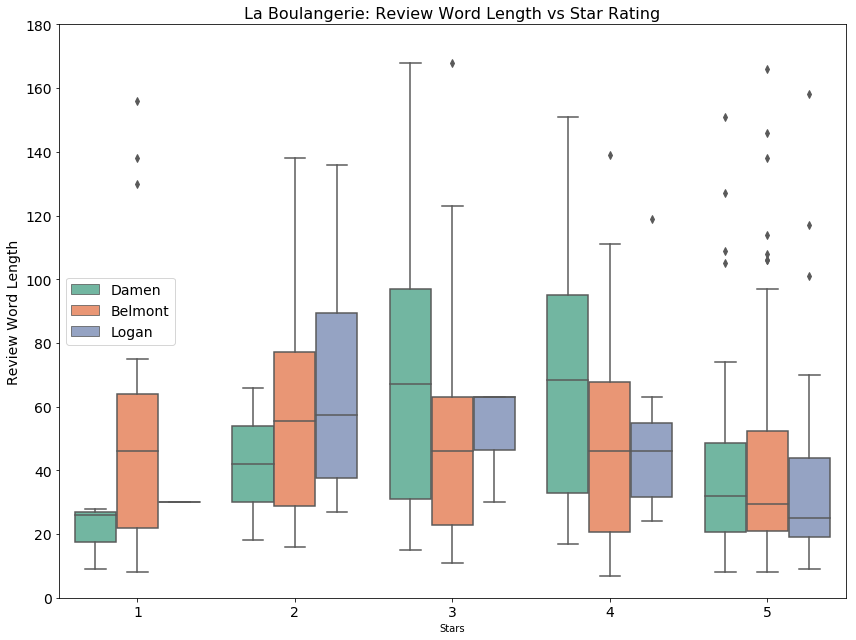

In [343]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.boxplot(x="Stars", y="Filtered Length", hue="Branch", data=boul_master_nlp_review_merge, palette="Set2")
ax.set_ylim(0, 180)
plt.title("La Boulangerie: Review Word Length vs Star Rating", fontsize=16)
plt.ylabel("Review Word Length", fontsize=14)
plt.legend(bbox_to_anchor=(.02, .98), loc=2, borderaxespad=0.)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/BoxPlot_Star_Length_Branch_comparisons.png')                       
                                 

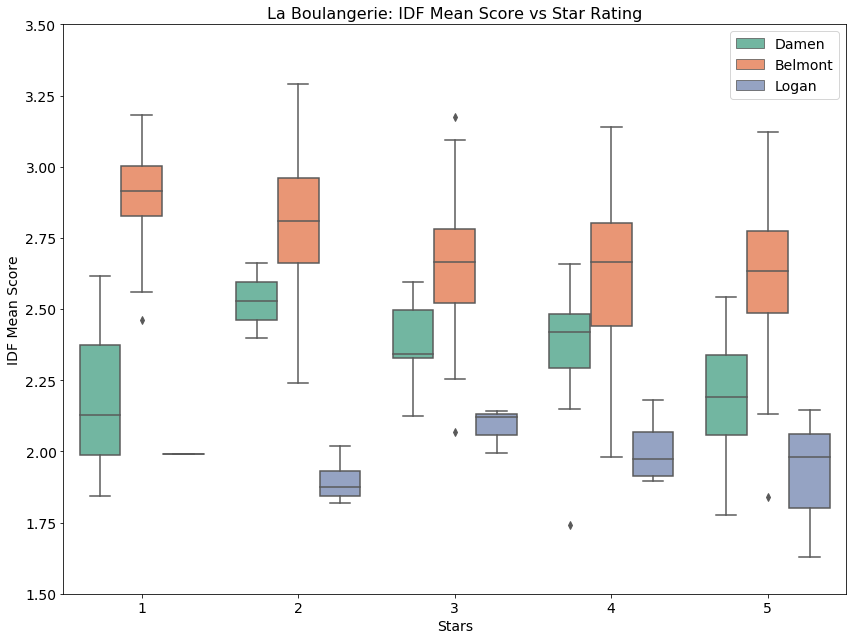

In [345]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.boxplot(x="Stars", y="IDF_Mean", hue="Branch", data=boul_master_nlp_review_merge, palette="Set2")
ax.set_ylim(1.5, 3.5)
plt.title("La Boulangerie: IDF Mean Score vs Star Rating", fontsize=16)
plt.ylabel("IDF Mean Score", fontsize=14)
plt.xlabel("Stars", fontsize=14)
plt.legend(bbox_to_anchor=(.02, .98), loc=2, borderaxespad=0.)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/BoxPlot_Star_IDF_Branch_comparisons.png')

In [282]:
boul_master_nlp_review_merge.columns

Index(['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text_x', 'Cool',
       'Funny', 'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars',
       'prev_date', 'prev_useful', 'prev_funny', 'prev_cool', 'user_friends',
       'user_link', 'user_location', 'user_photos', 'user_reviews',
       'compound sentiment', 'negative sentiment', 'neutral sentiment',
       'positive sentiment', 'id', 'Text_y', 'Words', 'Filtered',
       'HashedFilteredValues', 'Features', 'IDF_Mean', 'Branch', 'Branch_Num',
       'Filtered Length'],
      dtype='object')

In [288]:
boul_summary_df

,Branch,Branch_Num,Stars,compound sentiment,elite,IDF_Mean,Filtered Length
,,,,mean,mean,mean,mean
0,Belmont,2,1,-0.291068,0.000000,2.890426,56.640000
1,Belmont,2,2,0.199470,0.200000,2.805381,57.950000
2,Belmont,2,3,0.520212,0.120000,2.650187,54.520000
3,Belmont,2,4,0.850248,0.195652,2.631713,53.086957
4,Belmont,2,5,0.862583,0.116667,2.614232,44.650000
5,Damen,1,1,-0.007667,0.000000,2.195623,21.000000
6,Damen,1,2,0.809500,0.500000,2.529194,42.000000
7,Damen,1,3,0.640538,0.153846,2.378698,74.153846
8,Damen,1,4,0.879619,0.375000,2.371828,69.625000


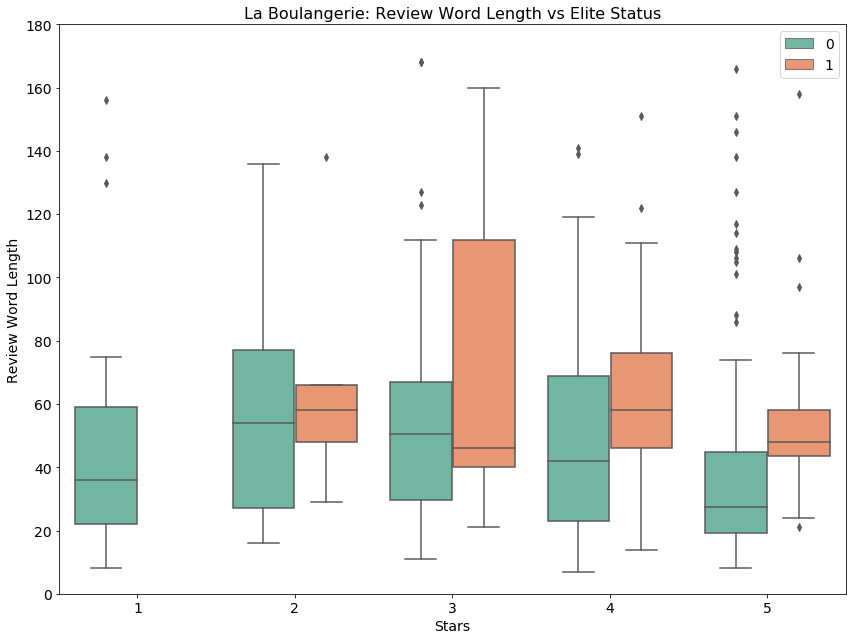

In [346]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.boxplot(x="Stars", y="Filtered Length", hue="elite", data=boul_master_nlp_review_merge, palette="Set2")
ax.set_ylim(0, 180)
plt.title("La Boulangerie: Review Word Length vs Elite Status", fontsize=16)
plt.ylabel("Review Word Length", fontsize=14)
plt.xlabel("Stars", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/BoxPlot_ReviewLength_Stars_Elite_comparisons.png')

No handles with labels found to put in legend.


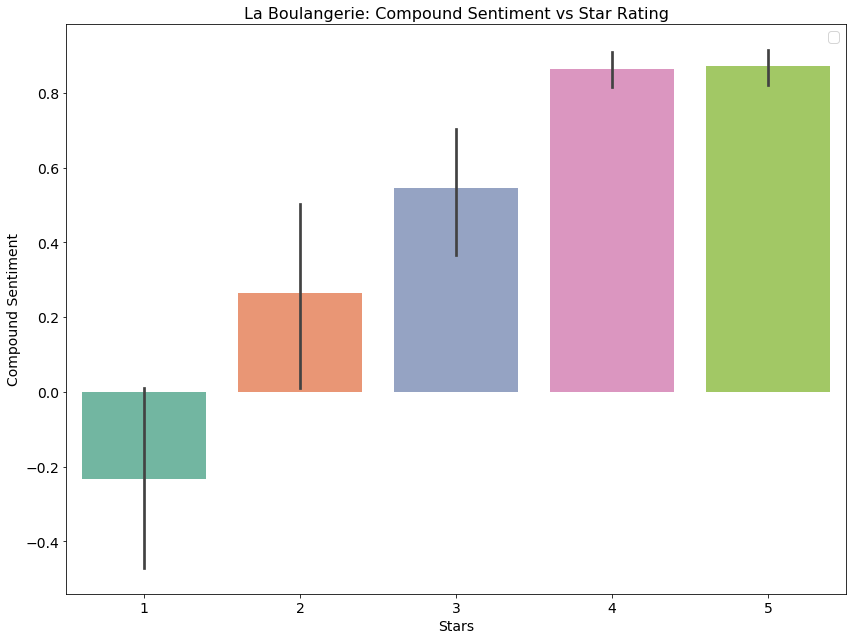

In [348]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x="Stars", y="compound sentiment", data=boul_master_nlp_review_merge, palette="Set2")
# ax.set_ylim(2.25, 3.0)
plt.title("La Boulangerie: Compound Sentiment vs Star Rating", fontsize=16)
plt.ylabel("Compound Sentiment", fontsize=14)
plt.xlabel("Stars", fontsize=14)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/BarPlot_Star_CompoundSent_comparisons.png')

In [324]:
boul_master_nlp_review_merge.groupby(['Branch'])['Stars', 'compound sentiment', 'elite', \
                                                 'IDF_Mean', 'Filtered Length'].agg(['mean', 'count', 'sum']).reset_index()

Branch     Stars            compound sentiment                     elite  \
                mean count  sum               mean count       sum      mean   
0  Belmont  3.545455   176  624           0.571502   176  100.5844  0.130682   
1    Damen  4.166667    72  300           0.798839    72   57.5164  0.208333   
2    Logan  4.236842    38  161           0.774905    38   29.4464  0.236842   

             IDF_Mean                   Filtered Length                
  count sum      mean count         sum            mean count     sum  
0   176  23  2.684861   176  472.535618       51.471591   176  9059.0  
1    72  15  2.274037    72  163.730670       53.444444    72  3848.0  
2    38   9  1.954335    38   74.264714       46.473684    38  1766.0

In [323]:
boul_master_nlp_review_merge.columns

Index(['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text_x', 'Cool',
       'Funny', 'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars',
       'prev_date', 'prev_useful', 'prev_funny', 'prev_cool', 'user_friends',
       'user_link', 'user_location', 'user_photos', 'user_reviews',
       'compound sentiment', 'negative sentiment', 'neutral sentiment',
       'positive sentiment', 'id', 'Text_y', 'Words', 'Filtered',
       'HashedFilteredValues', 'Features', 'IDF_Mean', 'Branch', 'Branch_Num',
       'Filtered Length'],
      dtype='object')

No handles with labels found to put in legend.


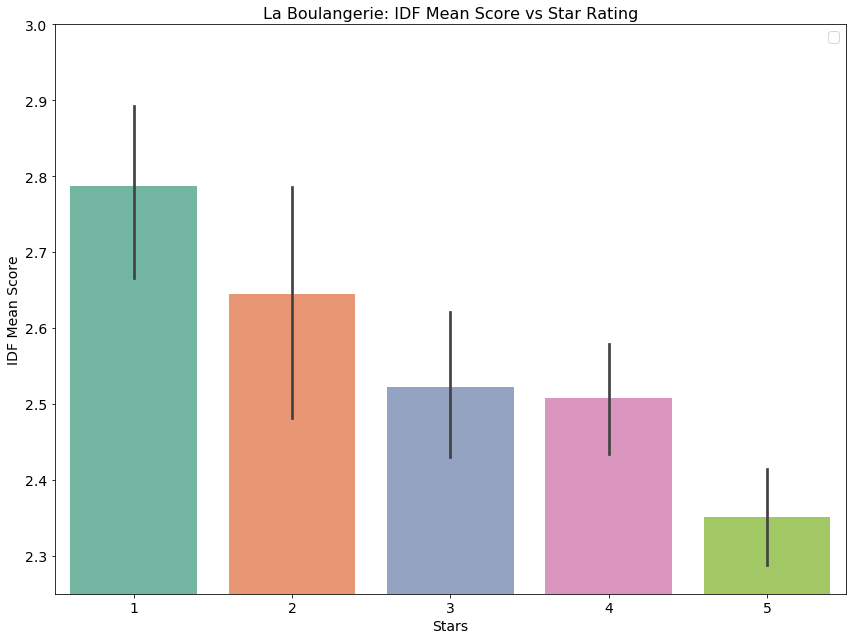

In [361]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x="Stars", y="IDF_Mean", data=boul_master_nlp_review_merge, palette="Set2")
ax.set_ylim(2.25, 3.0)
plt.title("La Boulangerie: IDF Mean Score vs Star Rating", fontsize=16)
plt.ylabel("IDF Mean Score", fontsize=14)
plt.xlabel("Stars", fontsize=14)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('../images/BarPlot_Star_IDF_comparisons.png')

In [362]:
boul_master_nlp_review_merge.columns

Index(['user_name', 'Date', 'Stars', 'Elite', 'Updated', 'Text_x', 'Cool',
       'Funny', 'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars',
       'prev_date', 'prev_useful', 'prev_funny', 'prev_cool', 'user_friends',
       'user_link', 'user_location', 'user_photos', 'Reviews', 'Sentiment',
       'negative sentiment', 'neutral sentiment', 'positive sentiment', 'id',
       'Text_y', 'Words', 'Filtered', 'HashedFilteredValues', 'Features',
       'IDF_Mean', 'Branch', 'Branch_Num', 'Word Count'],
      dtype='object')

In [364]:
# Damen 3848 total words
# Damen 1461 unique words
# Belmont 9059 total words
# Belmont 2473 unique words
# Logan 1766 total words
# Logan 833 unique words
# Fournette 6412 total words
# Fournette 1846 unique words

dlb_master = damen_master_array + logan_master_array + belmont_master_array

In [365]:
len(set(dlb_master))

3266

In [371]:
dlb_master_df = pd.DataFrame(dlb_master)
dlb_master_count_df = dlb_master_df.groupby([0])[0].agg(['count']).reset_index()
dlb_master_count_df.sort_values(['count'],ascending=False)


,0,count
1322,good,143
2188,place,137
1761,macaroons,133
2499,sandwich,119
1341,great,115
2501,sandwiches,112
430,bread,111
2029,one,110
1242,french,105
288,back,98


In [373]:
photo_list = []
for index, row in damen_nlp_review_merge.iterrows():
    photo_list = photo_list + row['Photos']
print(photo_list)

['https://s3-media3.fl.yelpcdn.com/bphoto/cjkFNdl2ls1zZA-oZt4fjg/348s.jpg', 'https://s3-media1.fl.yelpcdn.com/bphoto/U83E0Sh55kKeKM48_K7-Tw/168s.jpg', 'https://s3-media3.fl.yelpcdn.com/bphoto/RVS4jftM2xJF6QjIfsX80g/168s.jpg', 'https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8-oJyTMMKSQr7TVJxg/348s.jpg', 'https://s3-media4.fl.yelpcdn.com/bphoto/oLYVKGYRJ1Q53LJrBbQDlQ/348s.jpg', 'https://s3-media3.fl.yelpcdn.com/bphoto/V7vqiri3bWhnR6_Og3D1Rw/168s.jpg', 'https://s3-media4.fl.yelpcdn.com/bphoto/mCEC5RBQWaG1KbcaSJS4mQ/168s.jpg', 'https://s3-media3.fl.yelpcdn.com/bphoto/hwoFsaddgmbQx5igvbh9xg/348s.jpg', 'https://s3-media4.fl.yelpcdn.com/bphoto/E2TW_HGX6-rbVuiQ5hiDpw/348s.jpg', 'https://s3-media3.fl.yelpcdn.com/bphoto/-7Sa1xXVN7idZqHbhdW_cA/348s.jpg', 'https://s3-media2.fl.yelpcdn.com/bphoto/N0-CLwKLMhl1YqdoYzCIvw/168s.jpg', 'https://s3-media4.fl.yelpcdn.com/bphoto/oxAjHdk3_dYVeWwCr7AvNg/168s.jpg', 'https://s3-media3.fl.yelpcdn.com/bphoto/i43B7irOgbBOigZSzpmMOg/348s.jpg', 'https://s3-media1.fl.ye

In [374]:
photo_list

['https://s3-media3.fl.yelpcdn.com/bphoto/cjkFNdl2ls1zZA-oZt4fjg/348s.jpg',
 'https://s3-media1.fl.yelpcdn.com/bphoto/U83E0Sh55kKeKM48_K7-Tw/168s.jpg',
 'https://s3-media3.fl.yelpcdn.com/bphoto/RVS4jftM2xJF6QjIfsX80g/168s.jpg',
 'https://s3-media4.fl.yelpcdn.com/bphoto/SqCN8-oJyTMMKSQr7TVJxg/348s.jpg',
 'https://s3-media4.fl.yelpcdn.com/bphoto/oLYVKGYRJ1Q53LJrBbQDlQ/348s.jpg',
 'https://s3-media3.fl.yelpcdn.com/bphoto/V7vqiri3bWhnR6_Og3D1Rw/168s.jpg',
 'https://s3-media4.fl.yelpcdn.com/bphoto/mCEC5RBQWaG1KbcaSJS4mQ/168s.jpg',
 'https://s3-media3.fl.yelpcdn.com/bphoto/hwoFsaddgmbQx5igvbh9xg/348s.jpg',
 'https://s3-media4.fl.yelpcdn.com/bphoto/E2TW_HGX6-rbVuiQ5hiDpw/348s.jpg',
 'https://s3-media3.fl.yelpcdn.com/bphoto/-7Sa1xXVN7idZqHbhdW_cA/348s.jpg',
 'https://s3-media2.fl.yelpcdn.com/bphoto/N0-CLwKLMhl1YqdoYzCIvw/168s.jpg',
 'https://s3-media4.fl.yelpcdn.com/bphoto/oxAjHdk3_dYVeWwCr7AvNg/168s.jpg',
 'https://s3-media3.fl.yelpcdn.com/bphoto/i43B7irOgbBOigZSzpmMOg/348s.jpg',
 'https://s3

No handles with labels found to put in legend.


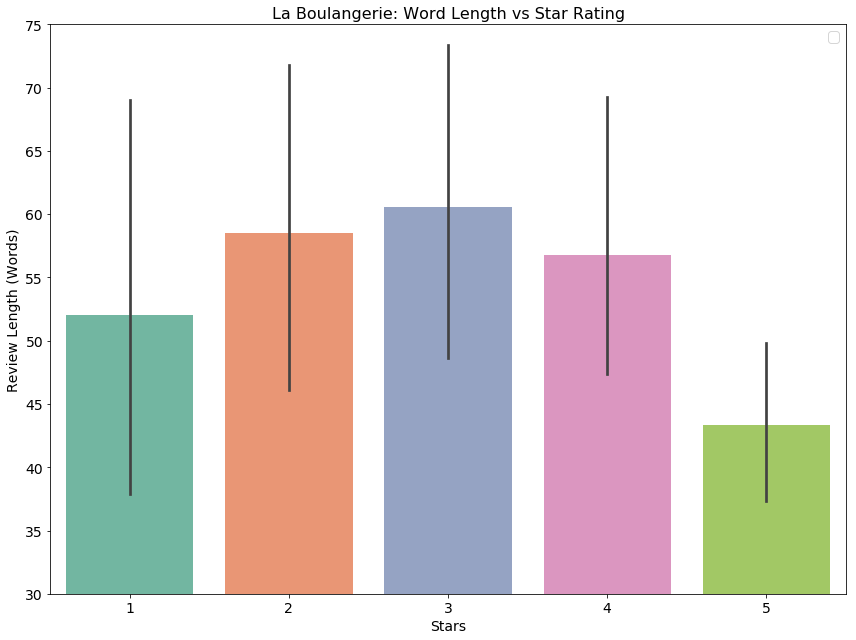

In [378]:
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x="Stars", y="Word Count", data=boul_master_nlp_review_merge, palette="Set2")
ax.set_ylim(30, 75)
plt.title("La Boulangerie: Word Length vs Star Rating", fontsize=16)
plt.ylabel("Review Length (Words)", fontsize=14)
plt.xlabel("Stars", fontsize=14)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
# plt.savefig('../images/BarPlot_Star_IDF_comparisons.png')

In [381]:
damen_min_IDF = min(damen_nlp_review_merge['IDF_Mean'].values)
belmont_min_IDF = min(belmont_nlp_review_merge['IDF_Mean'].values)
logan_min_IDF = min(logan_nlp_review_merge['IDF_Mean'].values)

In [386]:
damen_nlp_review_merge.loc[damen_nlp_review_merge['IDF_Mean'] == damen_min_IDF, ['Text_x']].values

array([['Great place to get good french pastries / bread. \xa0Very charming shop where my French husband could satisfy his hunger for "back home food and bread"']],
      dtype=object)

In [387]:
damen_min_IDF

1.7428764250559663

In [389]:
print(belmont_nlp_review_merge.loc[belmont_nlp_review_merge['IDF_Mean'] == belmont_min_IDF, ['Text_x']].values)
print(belmont_min_IDF)

[['Friendly staff and great service. \xa0Everything was so fresh. \xa0Sandwiches are great and pair creative ingredients. Great pastries and bread!']]
1.8414175549958227


In [390]:
print(logan_nlp_review_merge.loc[logan_nlp_review_merge['IDF_Mean'] == logan_min_IDF, ['Text_x']].values)
print(logan_min_IDF)

[["Delicious croissants! \xa0I was so excited when this opened as I love not having to wait until the the Sunday farmer's market to get amazing bread and croissants. \xa0YUM!"]]
1.6301912193731458


In [391]:
damen_max_IDF = max(damen_nlp_review_merge['IDF_Mean'].values)
belmont_max_IDF = max(belmont_nlp_review_merge['IDF_Mean'].values)
logan_max_IDF = max(logan_nlp_review_merge['IDF_Mean'].values)

In [396]:
damen_nlp_review_merge.loc[damen_nlp_review_merge['IDF_Mean'] == damen_max_IDF, ['user_link']].values
# print(damen_max_IDF)

array([['https://www.yelp.com/user_details?userid=j8VoJckjslfjIcOINVrr9Q']],
      dtype=object)

In [393]:
print(belmont_nlp_review_merge.loc[belmont_nlp_review_merge['IDF_Mean'] == belmont_max_IDF, ['Text_x']].values)
print(belmont_max_IDF)

[['Good tea and pastries but NO BATHROOM. The staff directed me across the street to use the Jamba Juice bathroom, which the Jamba Juice employees did not appreciate.']]
3.289219267232306


In [394]:
print(logan_nlp_review_merge.loc[logan_nlp_review_merge['IDF_Mean'] == logan_max_IDF, ['Text_x']].values)
print(logan_max_IDF)

[["*EDIT*Adding two stars because I've been in a couple times (to get carry-out) since writing the review below, and the store has dampened the sound of the bell on the door, making it less piercing. It's also possible they've gone a different direction with the music, but I haven't stayed long enough to tell for sure. Either way, definitely seems like it's improving, and I'm looking forward to trying out the outdoor seating once the weather's consistently nice!_________________________Been here five to ten times over the past few months, always on weekend mornings.The pastries are excellent.The drip coffee and espresso drinks are fine, but not as good as at New Wave or Intelligentsia.It's pretty unpleasant to sit inside for more than a minute, because:1. The bell on the front door, which rings every time someone enters or leaves, is unbelievably loud and piercing.2. The music is generally something like soft-rock hits of 2001 to 2010 (think a lot of James Blunt).3. There's a 100% chan

In [398]:
all_words = []
filtered_words = []
for index, row in boul_master_nlp_review_merge.iterrows():
    all_words = row['Words'] + all_words
    filtered_words = row['Filtered'] + filtered_words
print(len(all_words))
print(len(filtered_words))


29261
14673


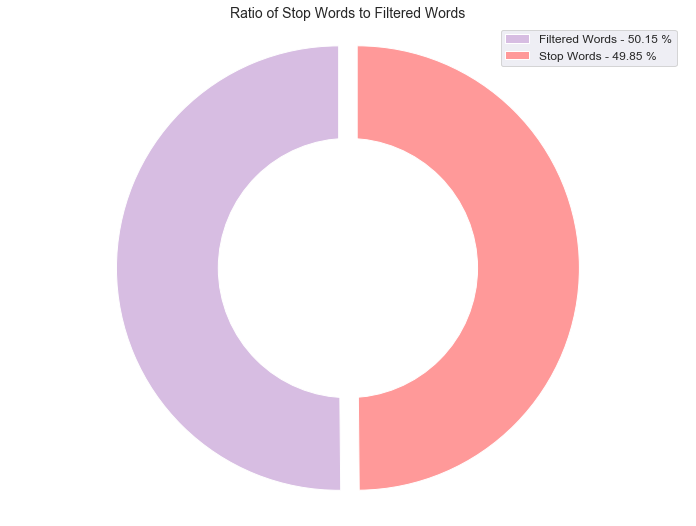

In [437]:
fig, ax = plt.subplots(figsize=(12, 9))
labels = ['Filtered Words', 'Stop Words']
values = [14673, 14588]
colors = ['#D7BDE2','#ff9999']
explode = (0.05, 0.05)
percent = [50.15, 49.85]

patches, texts = plt.pie(values, colors=colors, startangle=90, radius=1.2, explode=explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
labels_official = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]

sort_legend = True
if sort_legend:
    patches, labels_official, dummy =  zip(*sorted(zip(patches, labels_official, values),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels_official, loc='best', fontsize=12)
plt.axis('equal')
plt.title('Ratio of Stop Words to Filtered Words', fontsize=14)
plt.show()

In [416]:
df = pd.DataFrame(columns=['Total Words', 'Filtered Words', 'Stop Words'], data=[[29261, 14673, 14588]])

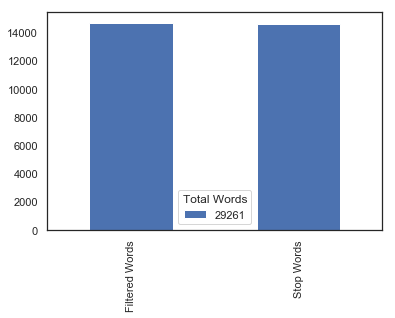

In [452]:
sns.set_style('white')
df.set_index('Total Words').T.plot(kind='bar', stacked=True)

In [415]:
df.head()

,Total Words,Filtered Words,Stop Words Removed
0,29261,14673,14588


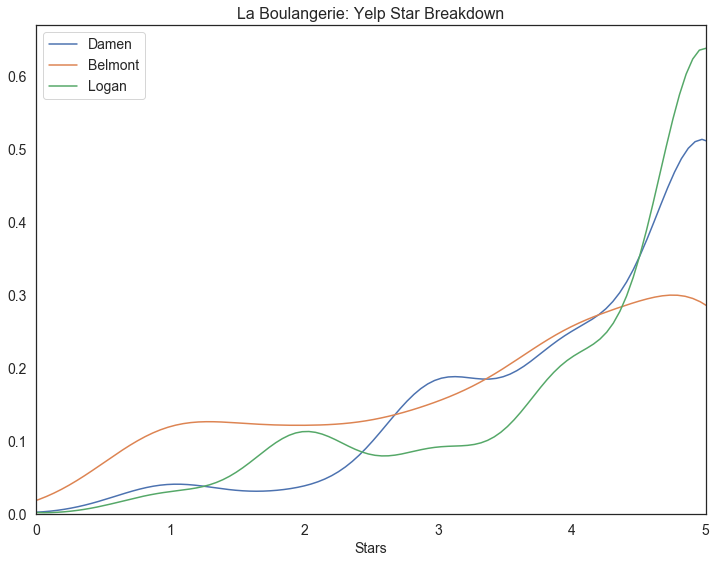

In [453]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim(0, 1)
sns.kdeplot(damen_nlp_review_merge['compound sentiment'], label='Damen')
sns.kdeplot(belmont_nlp_review_merge['compound sentiment'], label='Belmont')
sns.kdeplot(logan_nlp_review_merge['compound sentiment'], label='Logan')
plt.xlabel("Stars", fontsize=14)
plt.title("La Boulangerie: Yelp Star Breakdown", fontsize=16)
plt.legend(fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../images/boul_star_comparisons.png')

In [440]:
damen_nlp_review_merge.columns

Index(['user_name', 'Date', 'Stars', 'elite', 'Updated', 'Text_x', 'Cool',
       'Funny', 'Useful', 'check_ins', 'Photos', 'prev_text', 'prev_stars',
       'prev_date', 'prev_useful', 'prev_funny', 'prev_cool', 'user_friends',
       'user_link', 'user_location', 'user_photos', 'user_reviews',
       'compound sentiment', 'negative sentiment', 'neutral sentiment',
       'positive sentiment', 'id', 'Text_y', 'Words', 'Filtered',
       'HashedFilteredValues', 'Features', 'IDF_Mean', 'Branch', 'Branch_Num'],
      dtype='object')

In [458]:
boul_master_nlp_review_merge.loc[(boul_master_nlp_review_merge['Elite'] == 1) & \
                                 (boul_master_nlp_review_merge['Sentiment'] < 0) & \
                                (boul_master_nlp_review_merge['Stars'] == 5), ['Text_x']].values

array([["I've been dreaming of quiche and croissants as good as the ones I had in Paris. Everything here is phenomenal and baked daily. We've had all types of croissants, muffins, macaroons, and quiche here. My favorite is the salmon and leek quiche. Stop be here, it's a hidden gem. The bread is to die for and smells up the whole bakery."],
       ["So happy this place came about here! Right off the Logan blue line stop, plenty of sunlight, seating, macaroons & croissants, La Colombe coffee, and sweet service. In a neighborhood where most coffee shops are swamped, the coffee sucks, the bathrooms give you anxiety, everything is called vintage when really it's just garbage and dirty: this place is a freaking GEM. The coffee is great, there's plenty of space to sit, it's contemporary, the bathrooms are clean. You minus well get a whole box of macaroons because they're epic and you'll regret just getting one. The s'mores one, despite my reservations, was no disappointment."]],
      dtype=

In [463]:
from statistics import mean
damen_mean_IDF = mean(damen_nlp_review_merge['IDF_Mean'].values)
belmont_mean_IDF = mean(belmont_nlp_review_merge['IDF_Mean'].values)
logan_mean_IDF = mean(logan_nlp_review_merge['IDF_Mean'].values)

In [464]:
print(damen_mean_IDF)
print(belmont_mean_IDF)
print(logan_mean_IDF)

2.274037086733146
2.6848614669575843
1.954334581017354


In [466]:
mean(boul_master_nlp_review_merge['Sentiment'].values)

0.6557594405594406